In [4]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from scipy.integrate import solve_ivp
import scipy.optimize as sc_opt
import math
from scipy.integrate import quad
import time
from IPython.core.debugger import set_trace
import datetime as dt


from numpy import genfromtxt
import datetime

import sys
sys.path.append('../../models')
from models import firstordermodel, secondordermodel, thirdordermodel

sys.path.append('../')
from tools import stochasticSimulation, derive_regimes, discrete_ivp_solver, \
                    smooth_dap, sol_ivp_wrapper, sol_ivp_wrapper_discrete,\
                    smooth_regime, cost, sigmoid,\
                    simulate_MPC, mergeSwitchCont,\
                    build_initial_ipopt_object,\
                    consMatrix, constraintASparse, plotSwitches, setupAxis

from model_loader import *
from price_loader import *
from color_loader import *

import switching_times_1st as st1
import switching_times_1st as st2

def plotSwitches(switches,t0,c1,c2,ax):
    n_s = int(len(switches)/2)
    for xc in switches[:n_s]:
        ax.axvline(x=xc+t0,color = c1, alpha = 0.2)
    
    for xc in switches[n_s:]:
        ax.axvline(x=xc+t0,color = c2, alpha = 0.2)

def modification_date(filename):
    t = os.path.getmtime(filename)
    return datetime.datetime.fromtimestamp(t)

import matplotlib.patches as mpatches
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)


import seaborn as sns

sns.set(style='ticks', palette="Paired")


In [5]:
histories_02 = {}
histories_05 = {}
model_systems = ['m1','m2','m3']
n_s = 6
for model_sys in model_systems:
    filename_02 = '../results/sim_history/og_history_reuse_(2018-01-01 12:00:00)_(100_days)' + '_(price_slope_' + str(0.2) +  ')_(regime_slope_' + str(0.2) +  ')_(seed_1235)_(n_s_' + str(n_s) + ')_(sys_model_' + model_sys + ')_(sys_true_m4).npy'
    histories_02[model_sys] = np.load(filename_02,allow_pickle=True).item()
    filename_05 = '../results/sim_history/og_history_reuse_(2018-01-01 12:00:00)_(100_days)' + '_(price_slope_' + str(0.5) +  ')_(regime_slope_' + str(0.5) +  ')_(seed_1235)_(n_s_' + str(n_s) + ')_(sys_model_' + model_sys + ')_(sys_true_m4).npy'
    histories_05[model_sys] = np.load(filename_05,allow_pickle=True).item()


#mod_times.append(modification_date(filename))
    

## Objective functions

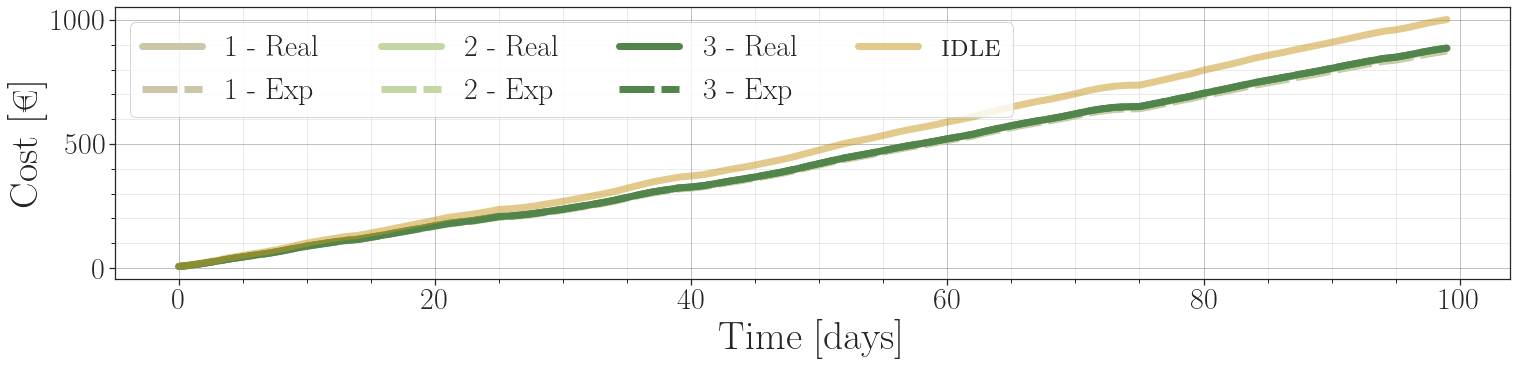

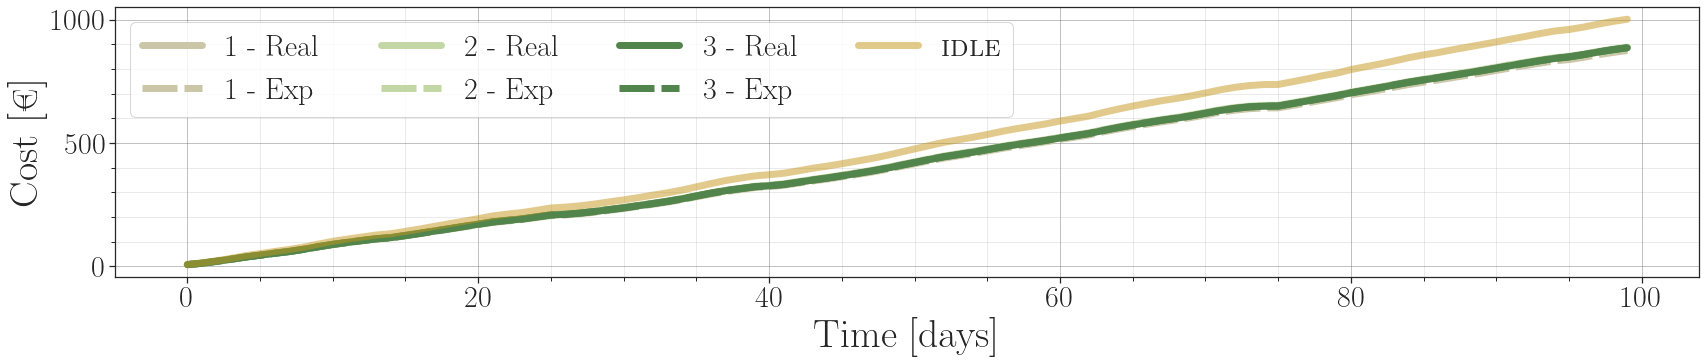

In [7]:
linewidth = 7

price_m1_02 = np.array([histories_02['m1']['price_true'][day][-1] for day in range(100)])
price_m2_02 = np.array([histories_02['m2']['price_true'][day][-1] for day in range(100)])
price_m3_02 = np.array([histories_02['m3']['price_true'][day][-1] for day in range(100)])
price_m1_05 = np.array([histories_05['m1']['price_true'][day][-1] for day in range(100)])
price_m2_05 = np.array([histories_05['m2']['price_true'][day][-1] for day in range(100)])
price_m3_05 = np.array([histories_05['m3']['price_true'][day][-1] for day in range(100)])

price_m1_02_exp = np.array([histories_02['m1']['price_model_dap'][day][-1] for day in range(100)])
price_m2_02_exp = np.array([histories_02['m2']['price_model_dap'][day][-1] for day in range(100)])
price_m3_02_exp = np.array([histories_02['m3']['price_model_dap'][day][-1] for day in range(100)])
price_m1_05_exp = np.array([histories_05['m1']['price_model_dap'][day][-1] for day in range(100)])
price_m2_05_exp = np.array([histories_05['m2']['price_model_dap'][day][-1] for day in range(100)])
price_m3_05_exp = np.array([histories_05['m3']['price_model_dap'][day][-1] for day in range(100)])

price_idle = np.array([histories_02['m1']['price_true_idle'][day][-1] for day in range(100)])

fig = plt.figure(figsize=(25,5))  
ax = fig.add_subplot(111)
ax.plot(price_m1_02,label= r'$\textnormal{1 - Real}$',color=col_mod1_line,linewidth=linewidth)
ax.plot(price_m1_02_exp,label= r'$\textnormal{1 - Exp}$',color=col_mod1_line,linestyle=exp_line_style,linewidth=linewidth)

ax.plot(price_m2_02,label= r'$\textnormal{2 - Real}$',color=col_mod2,linewidth=linewidth)
ax.plot(price_m2_02_exp,label= r'$\textnormal{2 - Exp}$',color=col_mod2,linestyle=exp_line_style,linewidth=linewidth)

ax.plot(price_m3_02,label= r'$\textnormal{3 - Real}$',color=col_mod3,linewidth=linewidth)
ax.plot(price_m3_02_exp,label= r'$\textnormal{3 - Exp}$',color=col_mod3,linestyle=exp_line_style,linewidth=linewidth)

ax.plot(price_idle,label= r'$\textsc{idle}$',color=col_idle,alpha = 0.5,linewidth=linewidth)

setupAxis(ax,ncol_legend=4)

ax.set_ylabel(r'$\textnormal{Cost [€]} $')
ax.set_xlabel(r'$\textnormal{Time [days]} $')
plt.savefig(FIGS + '/simulation/spot_longterm_cost_accu_02_reuse.pdf',format='pdf')


fig = plt.figure(figsize=(25,5))  
ax = fig.add_subplot(111)
ax.plot(price_m1_05,label= r'$\textnormal{1 - Real}$',color=col_mod1_line,linewidth=linewidth)
ax.plot(price_m1_05_exp,label= r'$\textnormal{1 - Exp}$',color=col_mod1_line,linestyle=exp_line_style,linewidth=linewidth)

ax.plot(price_m2_05,label= r'$\textnormal{2 - Real}$',color=col_mod2,linewidth=linewidth)
ax.plot(price_m2_05_exp,label= r'$\textnormal{2 - Exp}$',color=col_mod2,linestyle=exp_line_style,linewidth=linewidth)

ax.plot(price_m3_05,label= r'$\textnormal{3 - Real}$',color=col_mod3,linewidth=linewidth)
ax.plot(price_m3_05_exp,label= r'$\textnormal{3 - Exp}$',color=col_mod3,linestyle=exp_line_style,linewidth=linewidth)

ax.plot(price_idle,label= r'$\textsc{idle}$',color=col_idle,alpha = 0.5,linewidth=linewidth)

#ax.plot(rel_dap_m1,label= r'$\textnormal{Model 1 - Dap}$',color='black')
#ax.plot(rel_dap_m1_exp,label= r'$\textnormal{Model 1 - Dap}$',color='black',alpha = 0.5)
setupAxis(ax,ncol_legend=4)

ax.set_ylabel(r'$\textnormal{Cost [€]} $')
ax.set_xlabel(r'$\textnormal{Time [days]} $')

plt.subplots_adjust(hspace = 0.,bottom=0.2, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/spot_longterm_cost_accu_05_reuse.pdf',format='pdf')

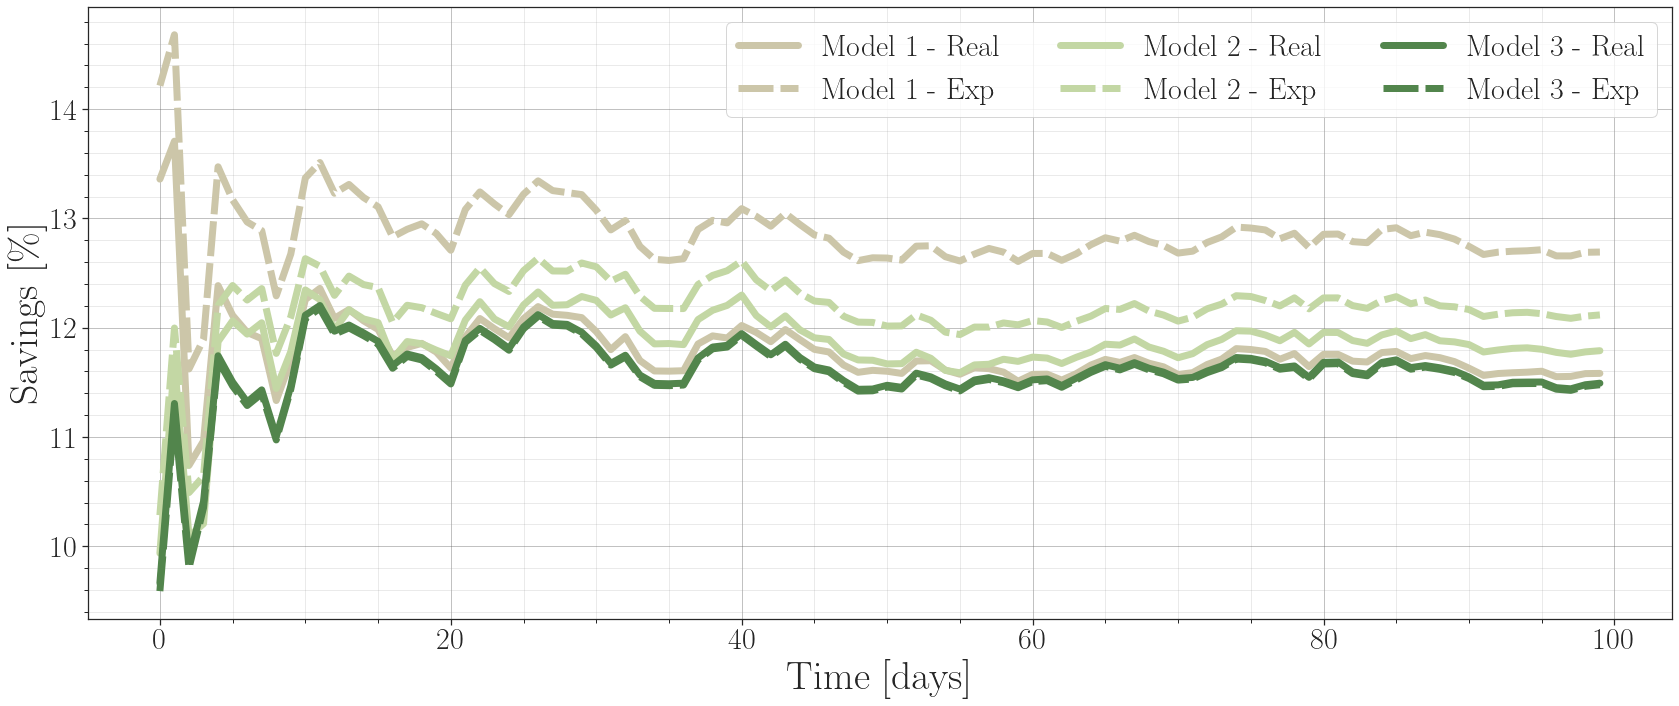

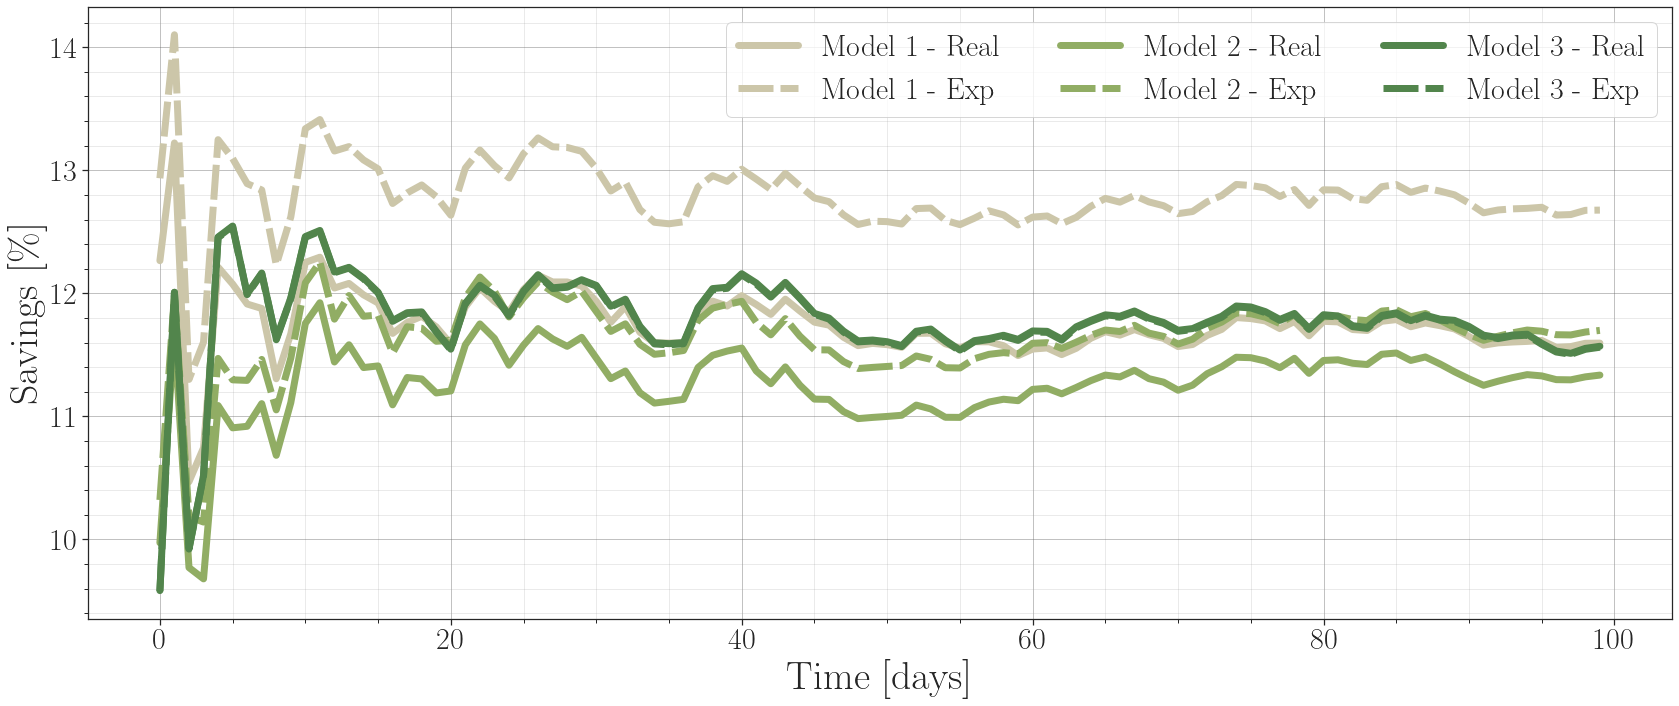

In [8]:
linewidth = 7

price_m1_02_save = (price_idle - price_m1_02)/price_idle
price_m2_02_save = (price_idle - price_m2_02)/price_idle
price_m3_02_save = (price_idle - price_m3_02)/price_idle
price_m1_05_save = (price_idle - price_m1_05)/price_idle
price_m2_05_save = (price_idle - price_m2_05)/price_idle
price_m3_05_save = (price_idle - price_m3_05)/price_idle

price_m1_02_save_exp = (price_idle - price_m1_02_exp)/price_idle
price_m2_02_save_exp = (price_idle - price_m2_02_exp)/price_idle
price_m3_02_save_exp = (price_idle - price_m3_02_exp)/price_idle
price_m1_05_save_exp = (price_idle - price_m1_05_exp)/price_idle
price_m2_05_save_exp = (price_idle - price_m2_05_exp)/price_idle
price_m3_05_save_exp = (price_idle - price_m3_05_exp)/price_idle

#price_idle = [histories_05['m3']['price_true_idle'][day][-1] for day in range(100)]


fig = plt.figure(figsize=(25,10))  
ax = fig.add_subplot(111)
ax.plot(price_m1_02_save,label= r'$\textnormal{Model 1 - Real}$',color=col_mod1_line,linewidth=linewidth)
ax.plot(price_m1_02_save_exp,label= r'$\textnormal{Model 1 - Exp}$',color=col_mod1_line,linestyle=exp_line_style,linewidth=linewidth)

ax.plot(price_m2_02_save,label= r'$\textnormal{Model 2 - Real}$',color=col_mod2,linewidth=linewidth)
ax.plot(price_m2_02_save_exp,label= r'$\textnormal{Model 2 - Exp}$',color=col_mod2,linestyle=exp_line_style,linewidth=linewidth)

ax.plot(price_m3_02_save,label= r'$\textnormal{Model 3 - Real}$',color=col_mod3,linewidth=linewidth)
ax.plot(price_m3_02_save_exp,label= r'$\textnormal{Model 3 - Exp}$',color=col_mod3,linestyle=exp_line_style,linewidth=linewidth)

#ax.plot(price_idle,label= r'$\textsc{idle}$',color=col_idle,alpha = 0.5,linewidth=linewidth)

#ax.plot(rel_dap_m1,label= r'$\textnormal{Model 1 - Dap}$',color='black')
#ax.plot(rel_dap_m1_exp,label= r'$\textnormal{Model 1 - Dap}$',color='black',alpha = 0.5)
setupAxis(ax,ncol_legend=3)

y_ticks = ax.get_yticks()
[str(int(100*y_ticks[i])) for i in range(len(y_ticks))]
ax.set_yticklabels(['$'+ str(int(100*y_ticks[i]))+'$' for i in range(len(y_ticks))])

ax.set_ylabel(r'$\textnormal{Savings [\%]} $')
ax.set_xlabel(r'$\textnormal{Time [days]} $')

plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/spot_longterm_save_accu_02_reuse.pdf',format='pdf')


fig = plt.figure(figsize=(25,10))  
ax = fig.add_subplot(111)
ax.plot(price_m1_05_save,label= r'$\textnormal{Model 1 - Real}$',color=col_mod1_line,linewidth=linewidth)
ax.plot(price_m1_05_save_exp,label= r'$\textnormal{Model 1 - Exp}$',color=col_mod1_line,linestyle=(0, (5, 1)),linewidth=linewidth)

ax.plot(price_m2_05_save,label= r'$\textnormal{Model 2 - Real}$',color=col_mod2_line,linewidth=linewidth)
ax.plot(price_m2_05_save_exp,label= r'$\textnormal{Model 2 - Exp}$',color=col_mod2_line,linestyle=(0, (5, 1)),linewidth=linewidth)

ax.plot(price_m3_05_save,label= r'$\textnormal{Model 3 - Real}$',color=col_mod3,linewidth=linewidth)
ax.plot(price_m3_05_save_exp,label= r'$\textnormal{Model 3 - Exp}$',linestyle=(0, (5, 1)),color=col_mod3,linewidth=linewidth)

#ax.plot(price_idle,label= r'$\textsc{idle}$',color=col_idle,alpha = 0.5,linewidth=linewidth)

#ax.plot(rel_dap_m1,label= r'$\textnormal{Model 1 - Dap}$',color='black')
#ax.plot(rel_dap_m1_exp,label= r'$\textnormal{Model 1 - Dap}$',color='black',alpha = 0.5)
setupAxis(ax,ncol_legend=3)

y_ticks = ax.get_yticks()
[str(int(100*y_ticks[i])) for i in range(len(y_ticks))]
ax.set_yticklabels(['$'+ str(int(100*y_ticks[i]))+'$' for i in range(len(y_ticks))])

ax.set_ylabel(r'$\textnormal{Savings [\%]} $')
ax.set_xlabel(r'$\textnormal{Time [days]} $')

plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/spot_longterm_save_accu_05_reuse.pdf',format='pdf')

In [9]:
price_m1_02 = [histories_02['m1']['price_true'][day][-1] - histories_02['m1']['price_true'][day][0] for day in range(100)]
price_m2_02 = [histories_02['m2']['price_true'][day][-1] - histories_02['m2']['price_true'][day][0] for day in range(100)]
price_m3_02 = [histories_02['m3']['price_true'][day][-1] - histories_02['m3']['price_true'][day][0] for day in range(100)]
price_m1_05 = [histories_05['m1']['price_true'][day][-1] - histories_05['m1']['price_true'][day][0] for day in range(100)]
price_m2_05 = [histories_05['m2']['price_true'][day][-1] - histories_05['m2']['price_true'][day][0] for day in range(100)]
price_m3_05 = [histories_05['m3']['price_true'][day][-1] - histories_05['m3']['price_true'][day][0] for day in range(100)]

price_m1_02_exp = [histories_02['m1']['price_model_dap'][day][-1] - histories_02['m1']['price_model_dap'][day][0] for day in range(100)]
price_m2_02_exp = [histories_02['m2']['price_model_dap'][day][-1] - histories_02['m2']['price_model_dap'][day][0] for day in range(100)]
price_m3_02_exp = [histories_02['m3']['price_model_dap'][day][-1] - histories_02['m3']['price_model_dap'][day][0] for day in range(100)]
price_m1_05_exp = [histories_05['m1']['price_model_dap'][day][-1] - histories_05['m1']['price_model_dap'][day][0] for day in range(100)]
price_m2_05_exp = [histories_05['m2']['price_model_dap'][day][-1] - histories_05['m2']['price_model_dap'][day][0] for day in range(100)]
price_m3_05_exp = [histories_05['m3']['price_model_dap'][day][-1] - histories_05['m3']['price_model_dap'][day][0] for day in range(100)]

price_idle_ech_day = [histories_05['m1']['price_true_idle'][day][-1] - histories_05['m1']['price_true_idle'][day][0] for day in range(100)]


In [10]:
save_m1_02 = (np.array(price_idle_ech_day) - np.array(price_m1_02)) / np.array(price_idle_ech_day) * 100
save_m2_02 = (np.array(price_idle_ech_day) - np.array(price_m2_02)) / np.array(price_idle_ech_day)* 100
save_m3_02 = (np.array(price_idle_ech_day) - np.array(price_m3_02)) / np.array(price_idle_ech_day)* 100
save_m1_05 = (np.array(price_idle_ech_day) - np.array(price_m1_05)) / np.array(price_idle_ech_day)* 100
save_m2_05 = (np.array(price_idle_ech_day) - np.array(price_m2_05)) / np.array(price_idle_ech_day)* 100
save_m3_05 = (np.array(price_idle_ech_day) - np.array(price_m3_05)) / np.array(price_idle_ech_day)* 100

save_m1_02_exp = (np.array(price_idle_ech_day) - np.array(price_m1_02_exp)) / np.array(price_idle_ech_day)* 100
save_m2_02_exp = (np.array(price_idle_ech_day) - np.array(price_m2_02_exp)) / np.array(price_idle_ech_day)* 100
save_m3_02_exp = (np.array(price_idle_ech_day) - np.array(price_m3_02_exp)) / np.array(price_idle_ech_day)* 100
save_m1_05_exp = (np.array(price_idle_ech_day) - np.array(price_m1_05_exp)) / np.array(price_idle_ech_day)* 100
save_m2_05_exp = (np.array(price_idle_ech_day) - np.array(price_m2_05_exp)) / np.array(price_idle_ech_day)* 100
save_m3_05_exp = (np.array(price_idle_ech_day) - np.array(price_m3_05_exp)) / np.array(price_idle_ech_day)* 100

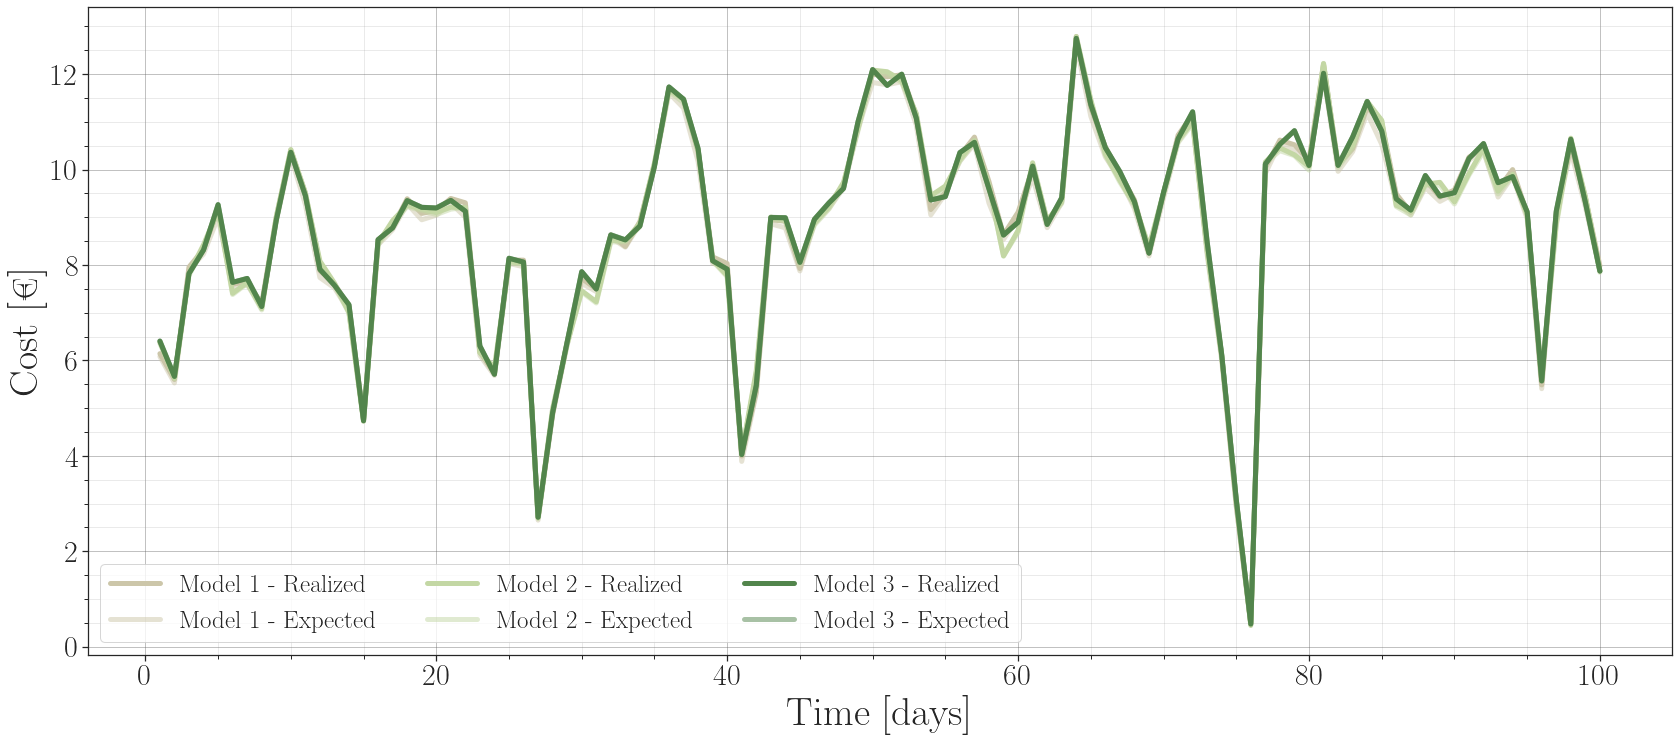

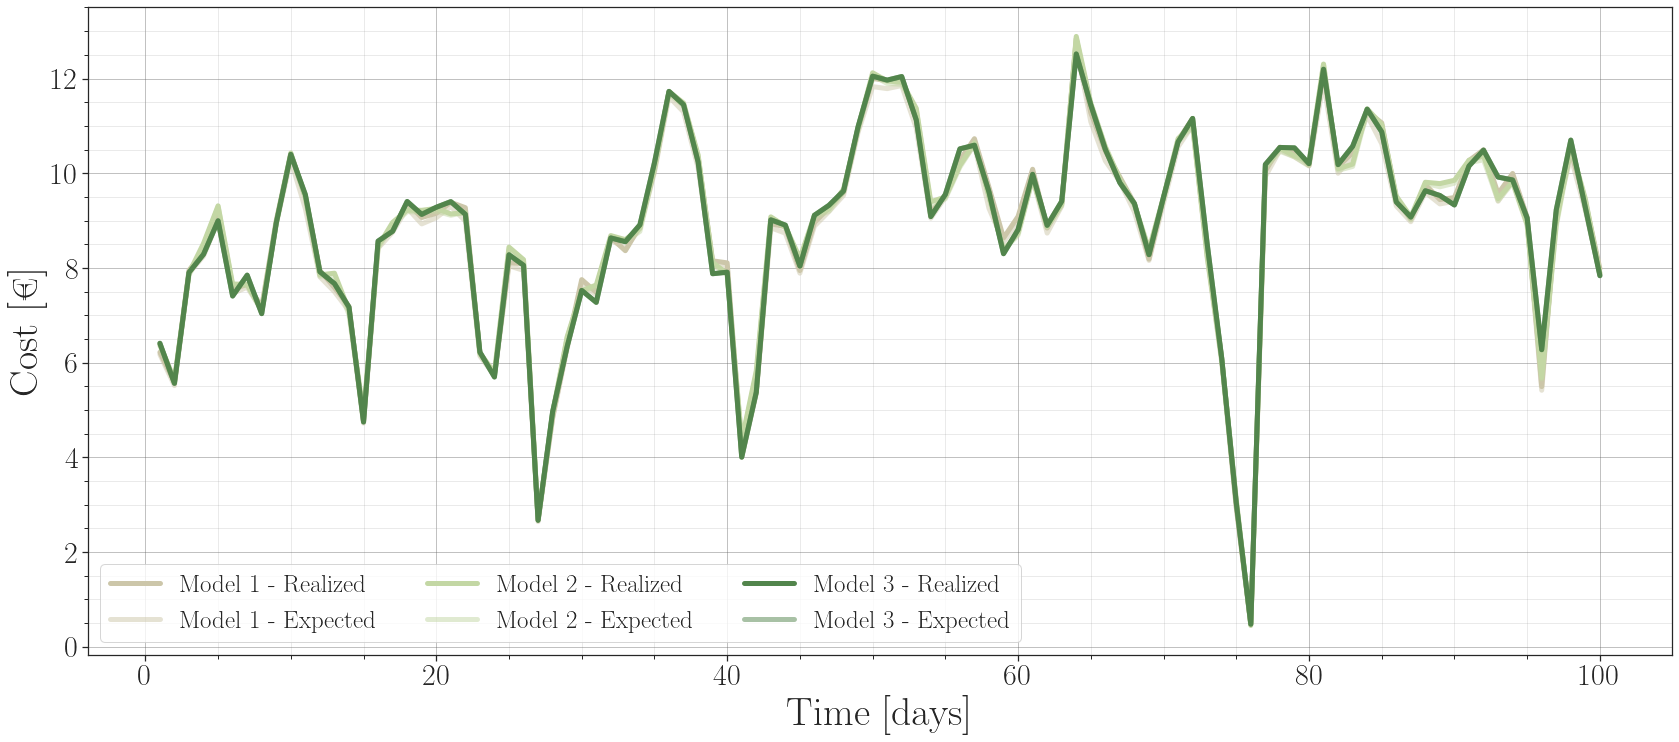

In [11]:
fig = plt.figure(figsize=(25,10))  
ax = fig.add_subplot(111)
linewidth=5
time = np.arange(1,101,1)
ax.plot(time,price_m1_02,label= r'$\textnormal{Model 1 - Realized}$',color=col_mod1_line,linewidth=linewidth)
ax.plot(time,price_m1_02_exp,label= r'$\textnormal{Model 1 - Expected}$',color=col_mod1_line,alpha = 0.5,linewidth=linewidth)

ax.plot(time,price_m2_02,label= r'$\textnormal{Model 2 - Realized}$',color=col_mod2,linewidth=linewidth)
ax.plot(time,price_m2_02_exp,label= r'$\textnormal{Model 2 - Expected}$',color=col_mod2,alpha = 0.5,linewidth=linewidth)

ax.plot(time,price_m3_02,label= r'$\textnormal{Model 3 - Realized}$',color=col_mod3,linewidth=linewidth)
ax.plot(time,price_m3_02_exp,label= r'$\textnormal{Model 3 - Expected}$',color=col_mod3,alpha = 0.5,linewidth=linewidth)
setupAxis(ax)
ax.legend(ncol=3,loc='lower left',prop={'size': 25})
ax.set_ylabel(r'$\textnormal{Cost [€]} $')
ax.set_xlabel(r'$\textnormal{Time [days]} $')

plt.subplots_adjust(hspace = 0.,bottom=0.05, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/spot_longterm_cost_ts_02_reuse.pdf',format='pdf')

fig = plt.figure(figsize=(25,10))  
ax = fig.add_subplot(111)
linewidth=5
time = np.arange(1,101,1)
ax.plot(time,price_m1_05,label= r'$\textnormal{Model 1 - Realized}$',color=col_mod1_line,linewidth=linewidth)
ax.plot(time,price_m1_05_exp,label= r'$\textnormal{Model 1 - Expected}$',color=col_mod1_line,alpha = 0.5,linewidth=linewidth)

ax.plot(time,price_m2_05,label= r'$\textnormal{Model 2 - Realized}$',color=col_mod2,linewidth=linewidth)
ax.plot(time,price_m2_05_exp,label= r'$\textnormal{Model 2 - Expected}$',color=col_mod2,alpha = 0.5,linewidth=linewidth)

ax.plot(time,price_m3_05,label= r'$\textnormal{Model 3 - Realized}$',color=col_mod3,linewidth=linewidth)
ax.plot(time,price_m3_05_exp,label= r'$\textnormal{Model 3 - Expected}$',color=col_mod3,alpha = 0.5,linewidth=linewidth)
setupAxis(ax)
ax.legend(ncol=3,loc='lower left',prop={'size': 25})
ax.set_ylabel(r'$\textnormal{Cost [€]} $')
ax.set_xlabel(r'$\textnormal{Time [days]} $')

plt.subplots_adjust(hspace = 0.,bottom=0.05, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/spot_longterm_cost_ts_05_reuse.pdf',format='pdf')



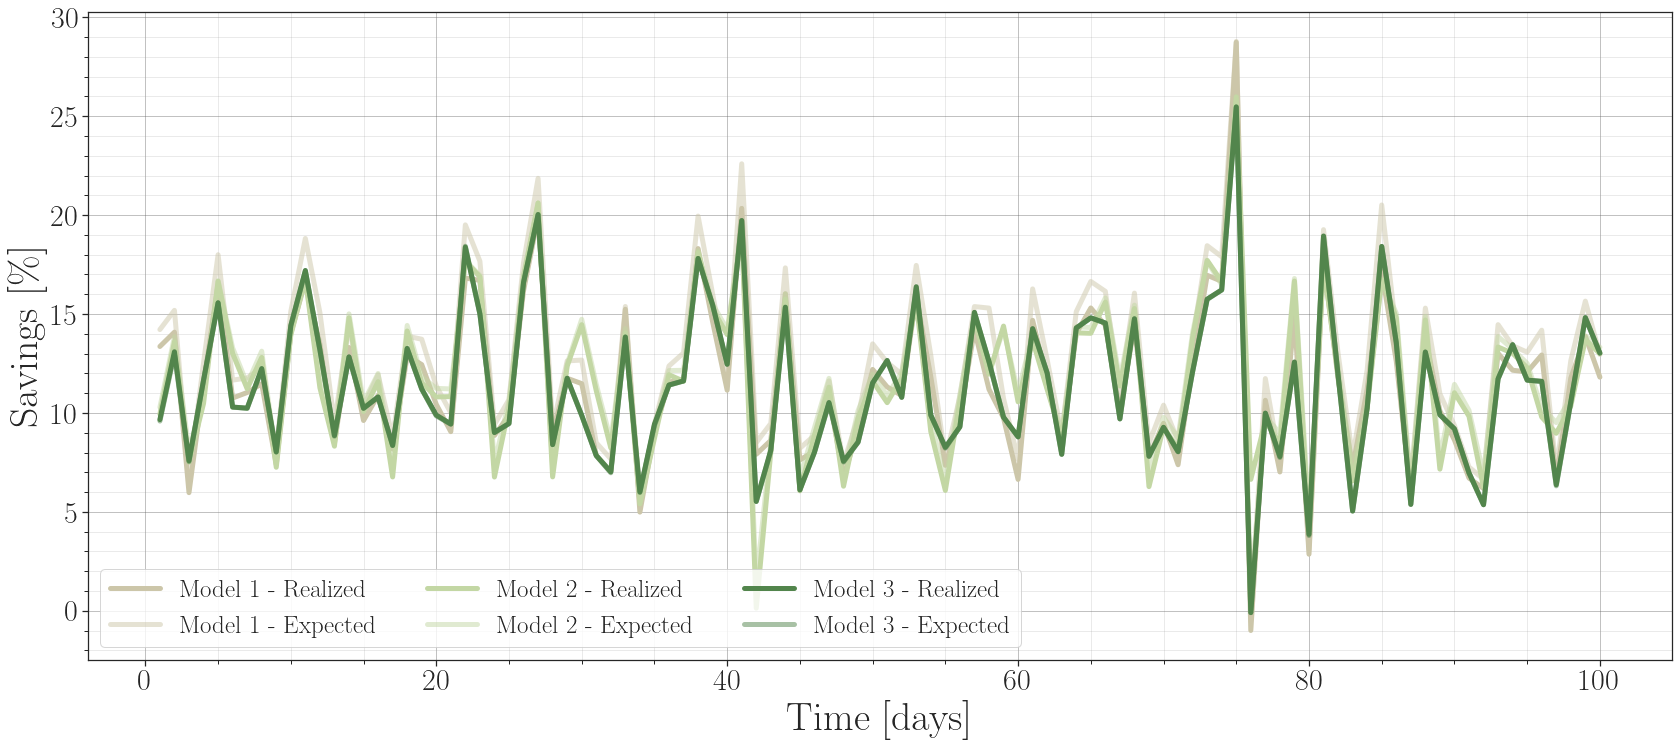

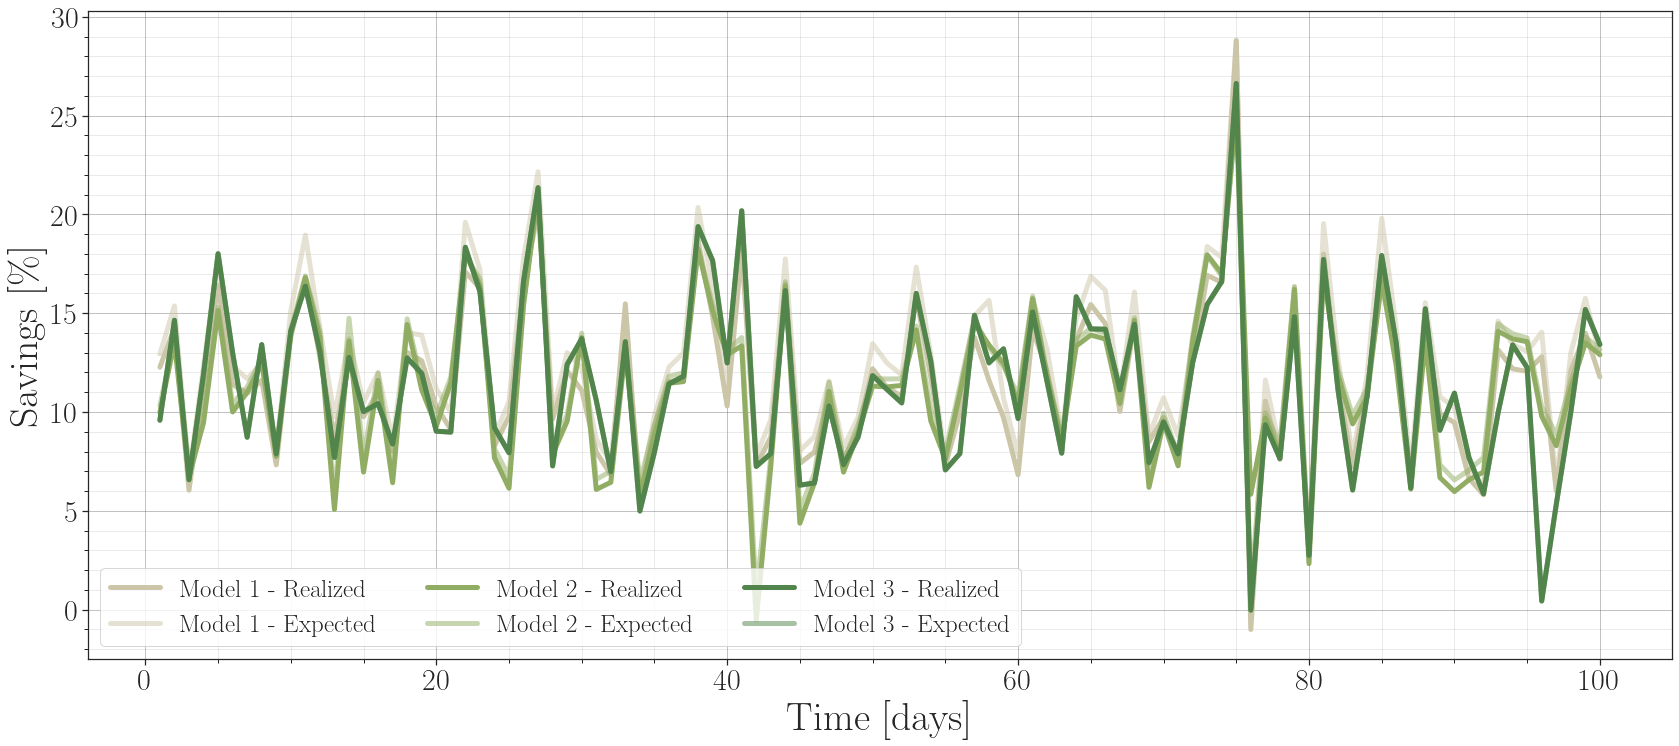

In [12]:
fig = plt.figure(figsize=(25,10))  
ax = fig.add_subplot(111)
time = np.arange(1,101,1)
linewidth=5
ax.plot(time,save_m1_02,label= r'$\textnormal{Model 1 - Realized}$',color=col_mod1_line,linewidth=linewidth)
ax.plot(time,save_m1_02_exp,label= r'$\textnormal{Model 1 - Expected}$',color=col_mod1_line,alpha = 0.5,linewidth=linewidth)

ax.plot(time,save_m2_02,label= r'$\textnormal{Model 2 - Realized}$',color=col_mod2,linewidth=linewidth)
ax.plot(time,save_m2_02_exp,label= r'$\textnormal{Model 2 - Expected}$',color=col_mod2,alpha = 0.5,linewidth=linewidth)

ax.plot(time,save_m3_02,label= r'$\textnormal{Model 3 - Realized}$',color=col_mod3,linewidth=linewidth)
ax.plot(time,save_m3_02_exp,label= r'$\textnormal{Model 3 - Expected}$',color=col_mod3,alpha = 0.5,linewidth=linewidth)
setupAxis(ax)
ax.legend(ncol=3,loc='lower left',prop={'size': 25})
ax.set_ylabel(r'$\textnormal{Savings [\%]} $')
ax.set_xlabel(r'$\textnormal{Time [days]} $')

plt.subplots_adjust(hspace = 0.,bottom=0.05, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/spot_longterm_save_ts_02_reuse.pdf',format='pdf')

fig = plt.figure(figsize=(25,10))  
ax = fig.add_subplot(111)
time = np.arange(1,101,1)
linewidth=5
ax.plot(time,save_m1_05,label= r'$\textnormal{Model 1 - Realized}$',color=col_mod1_line,linewidth=linewidth)
ax.plot(time,save_m1_05_exp,label= r'$\textnormal{Model 1 - Expected}$',color=col_mod1_line,alpha = 0.5,linewidth=linewidth)

ax.plot(time,save_m2_05,label= r'$\textnormal{Model 2 - Realized}$',color=col_mod2_line,linewidth=linewidth)
ax.plot(time,save_m2_05_exp,label= r'$\textnormal{Model 2 - Expected}$',color=col_mod2_line,alpha = 0.5,linewidth=linewidth)

ax.plot(time,save_m3_05,label= r'$\textnormal{Model 3 - Realized}$',color=col_mod3,linewidth=linewidth)
ax.plot(time,save_m3_05_exp,label= r'$\textnormal{Model 3 - Expected}$',color=col_mod3,alpha = 0.5,linewidth=linewidth)
setupAxis(ax)
ax.legend(ncol=3,loc='lower left',prop={'size': 25})
ax.set_ylabel(r'$\textnormal{Savings [\%]} $')
ax.set_xlabel(r'$\textnormal{Time [days]} $')

plt.subplots_adjust(hspace = 0.,bottom=0.05, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/spot_longterm_save_ts_05_reuse.pdf',format='pdf')



No handles with labels found to put in legend.


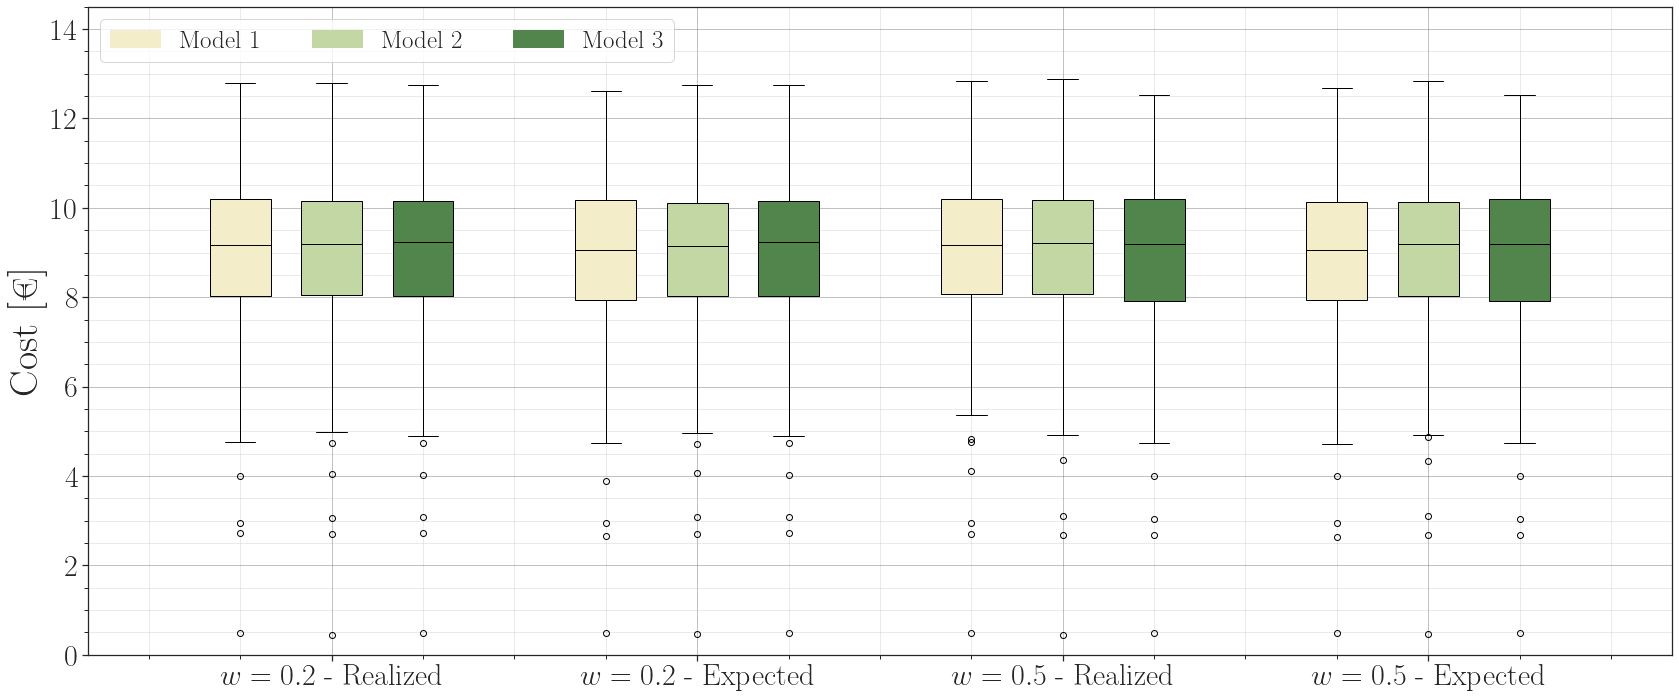

In [13]:
def set_box_color(bp, color_box, color_whish, col_caps, col_median, col_fill):
    plt.setp(bp['boxes'], color=color_box)
    plt.setp(bp['whiskers'], color=color_whish)
    plt.setp(bp['caps'], color=col_caps)
    plt.setp(bp['medians'], color=col_median)
    
    for box in bp['boxes']:
        box.set(facecolor = col_fill) 
    
fig = plt.figure(figsize=(25,10))   
ax1 = fig.add_subplot(111)
boxplot_data_m1 = np.vstack( (price_m1_02,price_m1_02_exp, price_m1_05,price_m1_05_exp))
boxplot_data_m2 = np.vstack( (price_m2_02,price_m2_02_exp, price_m2_05,price_m2_05_exp))
boxplot_data_m3 = np.vstack( (price_m3_02,price_m3_02_exp, price_m3_05,price_m3_05_exp))
bpl = ax1.boxplot(boxplot_data_m1.T, positions=np.array(range(len(boxplot_data_m1)))*1.2-0.3, widths=0.2, patch_artist=True)
bpr = ax1.boxplot(boxplot_data_m2.T, positions=np.array(range(len(boxplot_data_m2)))*1.2, widths=0.2, patch_artist=True)
bp3 = ax1.boxplot(boxplot_data_m3.T, positions=np.array(range(len(boxplot_data_m3)))*1.2+0.3, widths=0.2, patch_artist=True)


#print(colors1[5])
set_box_color(bpl, color_box = 'black', color_whish = 'black', col_caps = 'black', col_median = 'black',\
              col_fill = col_mod1)
set_box_color(bpr, color_box = 'black', color_whish = 'black', col_caps = 'black', col_median = 'black',\
              col_fill = col_mod2)
set_box_color(bp3, color_box = 'black', color_whish = 'black', col_caps = 'black', col_median = 'black',\
              col_fill = col_mod3)

setupAxis(ax1)
#ax1.set_xticks(range(0,6,2))
#ax1.set_xticklabels([r'$\textnormal{Model 1}$',r'$\textnormal{Model 1}$',r'$\textnormal{Model 1}$'])
ax1.yaxis.grid(True) # Hide the horizontal gridlines
#ax1.set_xlabel(r'$\textnormal{Number of cycles}$')
ax1.set_ylabel(r'$\textnormal{Cost [€]} $')
ax1.set_xticks(np.array([0,1.2,2.4,3.6]))
ax1.set_xticklabels([r'$w = 0.2\textnormal{ - Realized}$',r'$w = 0.2\textnormal{ - Expected}$',r'$w = 0.5\textnormal{ - Realized}$',r'$w = 0.5\textnormal{ - Expected}$'])
ax1.yaxis.grid(True) # Hide the horizontal gridlines
ax1.set_xlabel(r'')
ax1.set_ylabel(r'$\textnormal{Cost [€]} $')
ax1.minorticks_on()
ax1.set_ylim(0,14.5)
#ax1.set_xlim(-1.5,19)
model1_patch = mpatches.Patch(color=col_mod1, label=r'$\textnormal{Model 1} $')
model2_patch = mpatches.Patch(color=col_mod2, label=r'$\textnormal{Model 2} $')
model3_patch = mpatches.Patch(color=col_mod3, label=r'$\textnormal{Model 3} $')
ax1.legend(handles=[model1_patch, model2_patch, model3_patch],prop={'size': 25},ncol=4,loc='upper left')

plt.subplots_adjust(hspace = 0.,bottom=0.05, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/spot_longterm_boxplot_reuse.pdf',format='pdf')


No handles with labels found to put in legend.


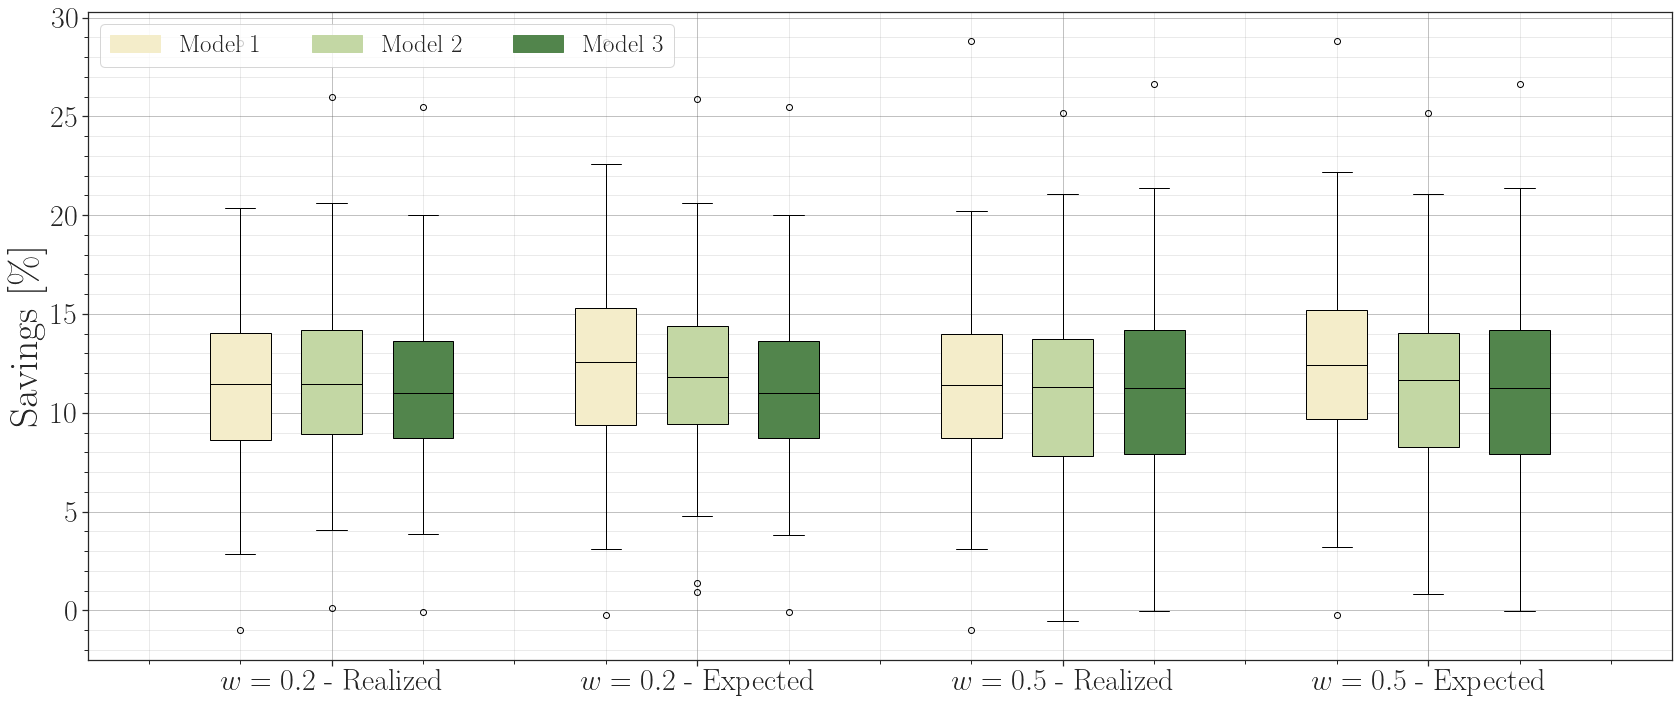

In [14]:
def set_box_color(bp, color_box, color_whish, col_caps, col_median, col_fill):
    plt.setp(bp['boxes'], color=color_box)
    plt.setp(bp['whiskers'], color=color_whish)
    plt.setp(bp['caps'], color=col_caps)
    plt.setp(bp['medians'], color=col_median)
    
    for box in bp['boxes']:
        box.set(facecolor = col_fill) 
    
fig = plt.figure(figsize=(25,10))   
ax1 = fig.add_subplot(111)
boxplot_data_m1 = np.vstack( (save_m1_02,save_m1_02_exp, save_m1_05,save_m1_05_exp))
boxplot_data_m2 = np.vstack( (save_m2_02,save_m2_02_exp, save_m2_05,save_m2_05_exp))
boxplot_data_m3 = np.vstack( (save_m3_02,save_m3_02_exp, save_m3_05,save_m3_05_exp))
bpl = ax1.boxplot(boxplot_data_m1.T, positions=np.array(range(len(boxplot_data_m1)))*1.2-0.3, widths=0.2, patch_artist=True)
bpr = ax1.boxplot(boxplot_data_m2.T, positions=np.array(range(len(boxplot_data_m2)))*1.2, widths=0.2, patch_artist=True)
bp3 = ax1.boxplot(boxplot_data_m3.T, positions=np.array(range(len(boxplot_data_m3)))*1.2+0.3, widths=0.2, patch_artist=True)


#print(colors1[5])
set_box_color(bpl, color_box = 'black', color_whish = 'black', col_caps = 'black', col_median = 'black',\
              col_fill = col_mod1)
set_box_color(bpr, color_box = 'black', color_whish = 'black', col_caps = 'black', col_median = 'black',\
              col_fill = col_mod2)
set_box_color(bp3, color_box = 'black', color_whish = 'black', col_caps = 'black', col_median = 'black',\
              col_fill = col_mod3)

setupAxis(ax1)
#ax1.set_xticks(range(0,6,2))
#ax1.set_xticklabels([r'$\textnormal{Model 1}$',r'$\textnormal{Model 1}$',r'$\textnormal{Model 1}$'])
ax1.yaxis.grid(True) # Hide the horizontal gridlines
#ax1.set_xlabel(r'$\textnormal{Number of cycles}$')
ax1.set_ylabel(r'$\textnormal{Cost [€]} $')
ax1.set_xticks(np.array([0,1.2,2.4,3.6]))
ax1.set_xticklabels([r'$w = 0.2\textnormal{ - Realized}$',r'$w = 0.2\textnormal{ - Expected}$',r'$w = 0.5\textnormal{ - Realized}$',r'$w = 0.5\textnormal{ - Expected}$'])
ax1.yaxis.grid(True) # Hide the horizontal gridlines
ax1.set_xlabel(r'')
ax1.set_ylabel(r'$\textnormal{Savings [\%]} $')
ax1.minorticks_on()
#ax1.set_ylim(0,1)
#ax1.set_xlim(-1.5,19)
model1_patch = mpatches.Patch(color=col_mod1, label=r'$\textnormal{Model 1} $')
model2_patch = mpatches.Patch(color=col_mod2, label=r'$\textnormal{Model 2} $')
model3_patch = mpatches.Patch(color=col_mod3, label=r'$\textnormal{Model 3} $')
ax1.legend(handles=[model1_patch, model2_patch, model3_patch],prop={'size': 25},ncol=4,loc='upper left')

plt.subplots_adjust(hspace = 0.,bottom=0.05, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/spot_longterm_boxplot_save_reuse.pdf',format='pdf')


# Specific days

/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in true_divide
/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in true_divide
/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in true_divide
/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide


spot                      33.42
down                     -10.01
up                        33.41
market_spot                   0
market_down                   1
market_up                     0
RK                       -10.01
t_sin               1.22465e-16
market_class_all              0
Name: 2018-02-25 12:00:00, dtype: object


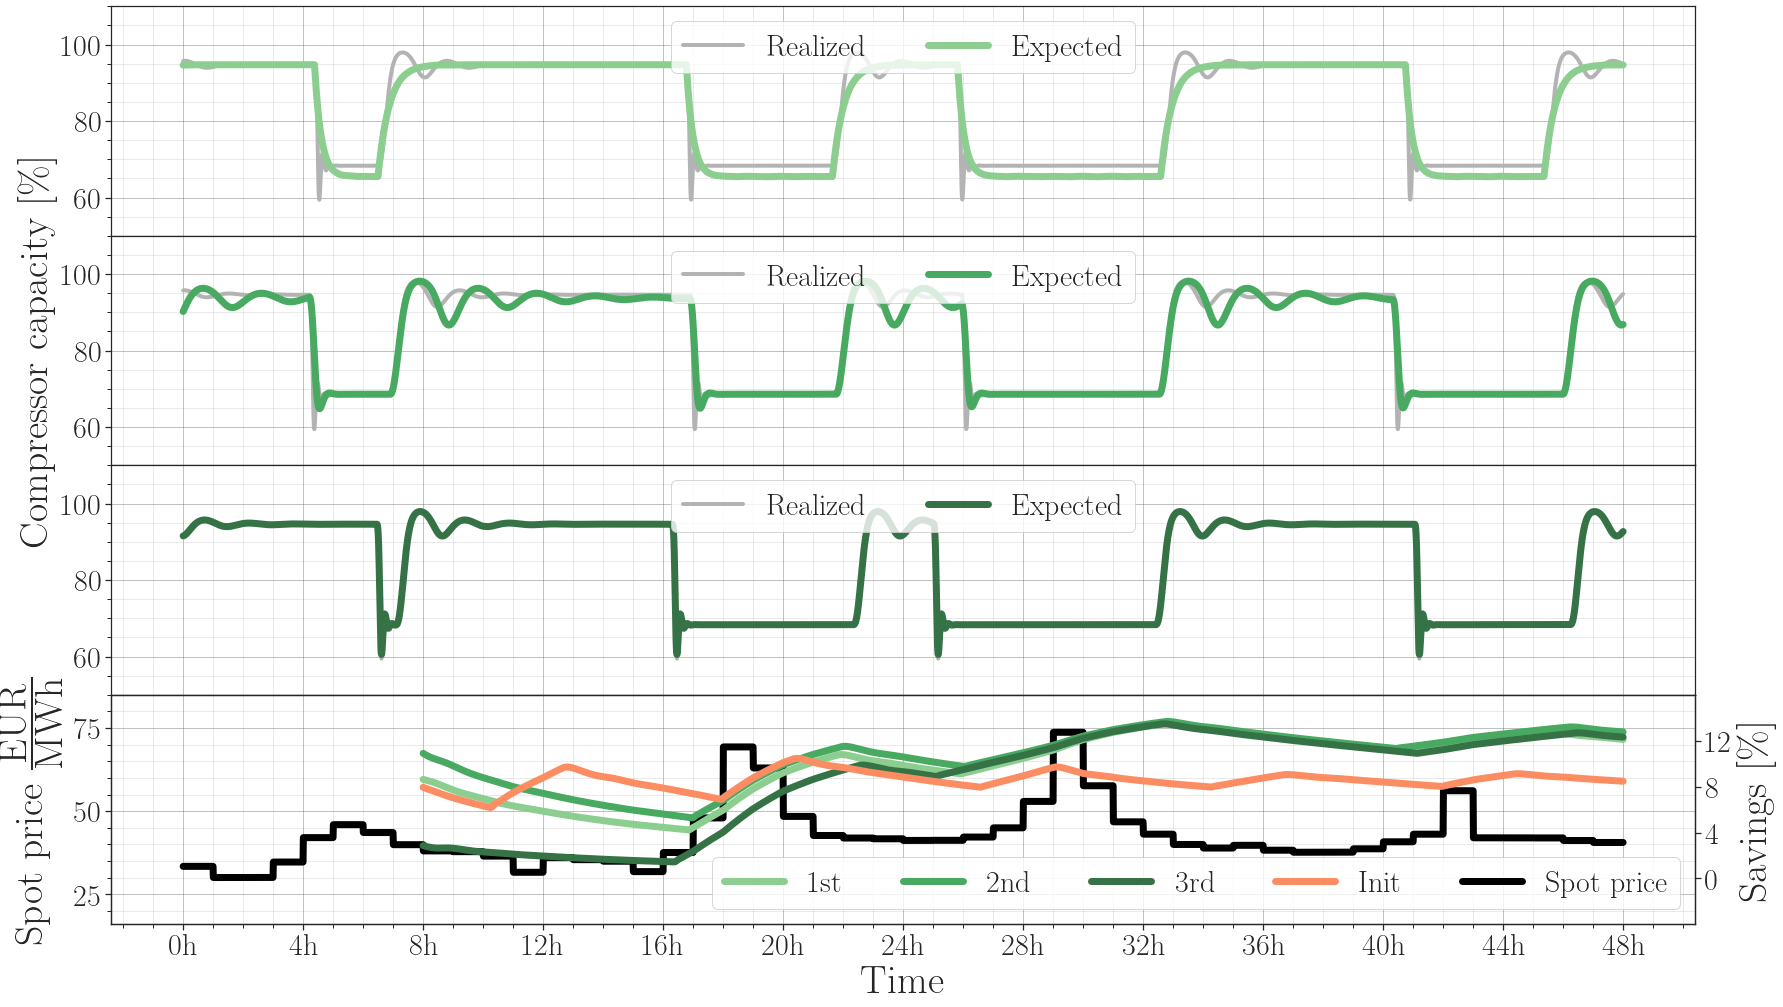

In [15]:
price_slope = 1.
days_to_plot = range(55,57)
linewidth1 = 4
linewidth2 = 7
n_skip_x = 4
histories = histories_02

fig = plt.figure(figsize=(25,15))   
ax1 = fig.add_subplot(411)

price_idle_plot =np.concatenate([histories['m1']['price_true_idle'][day] for day in days_to_plot]) - histories['m1']['price_true_idle'][days_to_plot[0]][0]

model = 'm1'
Z_model_true_plot_m1 =np.concatenate([histories[model]['Z_true'][day][0] for day in days_to_plot])
Z_model_dap_plot_m1 = np.concatenate([histories[model]['Z_model_dap'][day][0] for day in days_to_plot])
T_plot = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])
price_true_plot_m1 =np.concatenate([histories[model]['price_true'][day] for day in days_to_plot]) - histories[model]['price_true'][days_to_plot[0]][0]


ax1.plot(T_plot,100*Z_model_true_plot_m1,markersize=10,color = sns.color_palette("Set2")[-1], label=r'$\textnormal{Realized}$',alpha = 1.,linewidth=linewidth1)
ax1.plot(T_plot ,100*Z_model_dap_plot_m1,color = greens[5], label=r'$\textnormal{Expected}$',linewidth=linewidth2)

total_number_of_days = (days_to_plot[-1] - days_to_plot[0]) + 1
ax1.set_xticks(np.arange(0,total_number_of_days*25,n_skip_x)*(60.) + days_to_plot[0] * 60 * 24)
ax1.set_xticklabels(['' for _t in np.arange(0,total_number_of_days*25,n_skip_x) * 60.])
ax1.set_yticks([60, 80, 100])
setupAxis(ax1,ncol_legend = 3)
ax1.set_xlabel(r'')
ax1.set_ylabel(r'')
ax1.set_ylim(50,110)
ax1.legend(prop={'size': 30},ncol=2,loc = 'upper center')


 
ax2 = fig.add_subplot(412)

model = 'm2'
Z_model_true_plot_m2 =np.concatenate([histories[model]['Z_true'][day][0] for day in days_to_plot])
Z_model_dap_plot_m2 = np.concatenate([histories[model]['Z_model_dap'][day][0] for day in days_to_plot])
T_plot = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])
price_true_plot_m2 =np.concatenate([histories[model]['price_true'][day] for day in days_to_plot]) - histories[model]['price_true'][days_to_plot[0]][0]

ax2.plot(T_plot,100*Z_model_true_plot_m2,markersize=10,color = sns.color_palette("Set2")[-1], label=r'$\textnormal{Realized}$',alpha = 1.,linewidth=linewidth1)
ax2.plot(T_plot ,100*Z_model_dap_plot_m2,color = greens[3], label=r'$\textnormal{Expected}$',linewidth=linewidth2)

total_number_of_days = (days_to_plot[-1] - days_to_plot[0]) + 1
ax2.set_xticks(np.arange(0,total_number_of_days*25,n_skip_x)*(60.) + days_to_plot[0] * 60 * 24)
ax2.set_xticklabels(['' for _t in np.arange(0,total_number_of_days*25,n_skip_x) * 60.])
ax2.set_yticks([60, 80, 100])
setupAxis(ax2,ncol_legend = 3)
ax2.set_ylabel(r'$\textnormal{Compressor capacity [\%]} $')
ax2.set_xlabel(r'')
ax2.set_ylim(50,110)
ax2.legend(prop={'size': 30},ncol=2,loc = 'upper center')



  
ax3 = fig.add_subplot(413)
model = 'm3'
Z_model_true_plot_m3 =np.concatenate([histories[model]['Z_true'][day][0] for day in days_to_plot])
Z_model_dap_plot_m3 = np.concatenate([histories[model]['Z_model_dap'][day][0] for day in days_to_plot])
T_plot = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])
price_true_plot_m3 =np.concatenate([histories[model]['price_true'][day] for day in days_to_plot]) - histories[model]['price_true'][days_to_plot[0]][0]

ax3.plot(T_plot,100*Z_model_true_plot_m3,markersize=10,color = sns.color_palette("Set2")[-1], label=r'$\textnormal{Realized}$',alpha = 1.,linewidth=linewidth1)
ax3.plot(T_plot ,100*Z_model_dap_plot_m3,color = greens[1], label=r'$\textnormal{Expected}$',linewidth=linewidth2)

total_number_of_days = (days_to_plot[-1] - days_to_plot[0]) + 1
ax3.set_xticks(np.arange(0,total_number_of_days*25,n_skip_x)*(60.) + days_to_plot[0] * 60 * 24)
ax3.set_xticklabels(['' for _t in np.arange(0,total_number_of_days*25,n_skip_x) * 60.])
ax3.set_yticks([60, 80, 100])
setupAxis(ax3,ncol_legend = 3)
ax3.set_xlabel(r'')
ax3.set_ylabel(r'')
ax3.set_ylim(50,110)
ax3.legend(prop={'size': 30},ncol=2,loc = 'upper center')


price_true_plot_init =np.concatenate([histories[model]['price_true_init_switch'][day] for day in days_to_plot]) - histories[model]['price_true_init_switch'][days_to_plot[0]][0]



ax5 = fig.add_subplot(414)
all_dap = np.concatenate([histories[model]['PRICES_dap'][day,:24] for day in days_to_plot])
all_time = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])

lprice = ax5.plot(all_time,smooth_dap(all_time - all_time[0],all_dap,100,48),color='black',linewidth=linewidth2, label=r'$\textnormal{Spot price}$')

#ax4.plot(all_time,smooth_dap(all_time - all_time[0],all_dap,0.2,48),color=red[2],linewidth=linewidth1)
ax5.set_xticks(np.arange(0,total_number_of_days*25,4)*(60.) + days_to_plot[0] * 60 * 24)
ax5.set_xticklabels(['$'+str(int(_t/60.)) + r' \textnormal{h}$' for _t in np.arange(0,total_number_of_days*25,4) * 60.])
setupAxis(ax5,ncol_legend = 3,nolegend=True)
ax5.set_ylabel(r'$\textnormal{Spot price } \frac{\textnormal{EUR}}{\textnormal{MWh}}$')
ax5.set_xlabel(r'$\textnormal{Time} $')


ax5.set_ylim(16,85)

ax5_2 = ax5.twinx()
l1 = ax5_2.plot(all_time[2400:],(100*(price_idle_plot - price_true_plot_m1)/price_idle_plot)[2400:],color=greens[5],linewidth=linewidth2, label=r'$\textnormal{1st}$')
l2 = ax5_2.plot(all_time[2400:],(100*(price_idle_plot - price_true_plot_m2)/price_idle_plot)[2400:],color=greens[3],linewidth=linewidth2, label=r'$\textnormal{2nd}$')
l3 = ax5_2.plot(all_time[2400:],(100*(price_idle_plot - price_true_plot_m3)/price_idle_plot)[2400:],color=greens[1],linewidth=linewidth2, label=r'$\textnormal{3rd}$')
l4 = ax5_2.plot(all_time[2400:],(100*(price_idle_plot - price_true_plot_init)/price_idle_plot)[2400:],color=sns.color_palette("Set2")[1],linewidth=linewidth2, label=r'$\textnormal{Init}$')

ax5_2.set_yticks(np.array([0,4,8,12]))
ax5_2.set_ylabel(r'$\textnormal{Savings [\%]}$', fontsize=40)

ax5_2.tick_params(axis="y", labelsize=30)

lns = l1+l2+l3+l4+lprice
labs = [l.get_label() for l in lns]
ax5_2.legend(lns, labs,ncol=5,prop={'size': 30})
ax5_2.set_ylim(-4,16)




plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/specific_day_reuse.pdf',format='pdf')

prices_used = prices['2018-01-01 12:00:00':]
print(prices_used.iloc[(24*days_to_plot[0])])


/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide
/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in true_divide
/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in true_divide


spot                      33.42
down                     -10.01
up                        33.41
market_spot                   0
market_down                   1
market_up                     0
RK                       -10.01
t_sin               1.22465e-16
market_class_all              0
Name: 2018-02-25 12:00:00, dtype: object


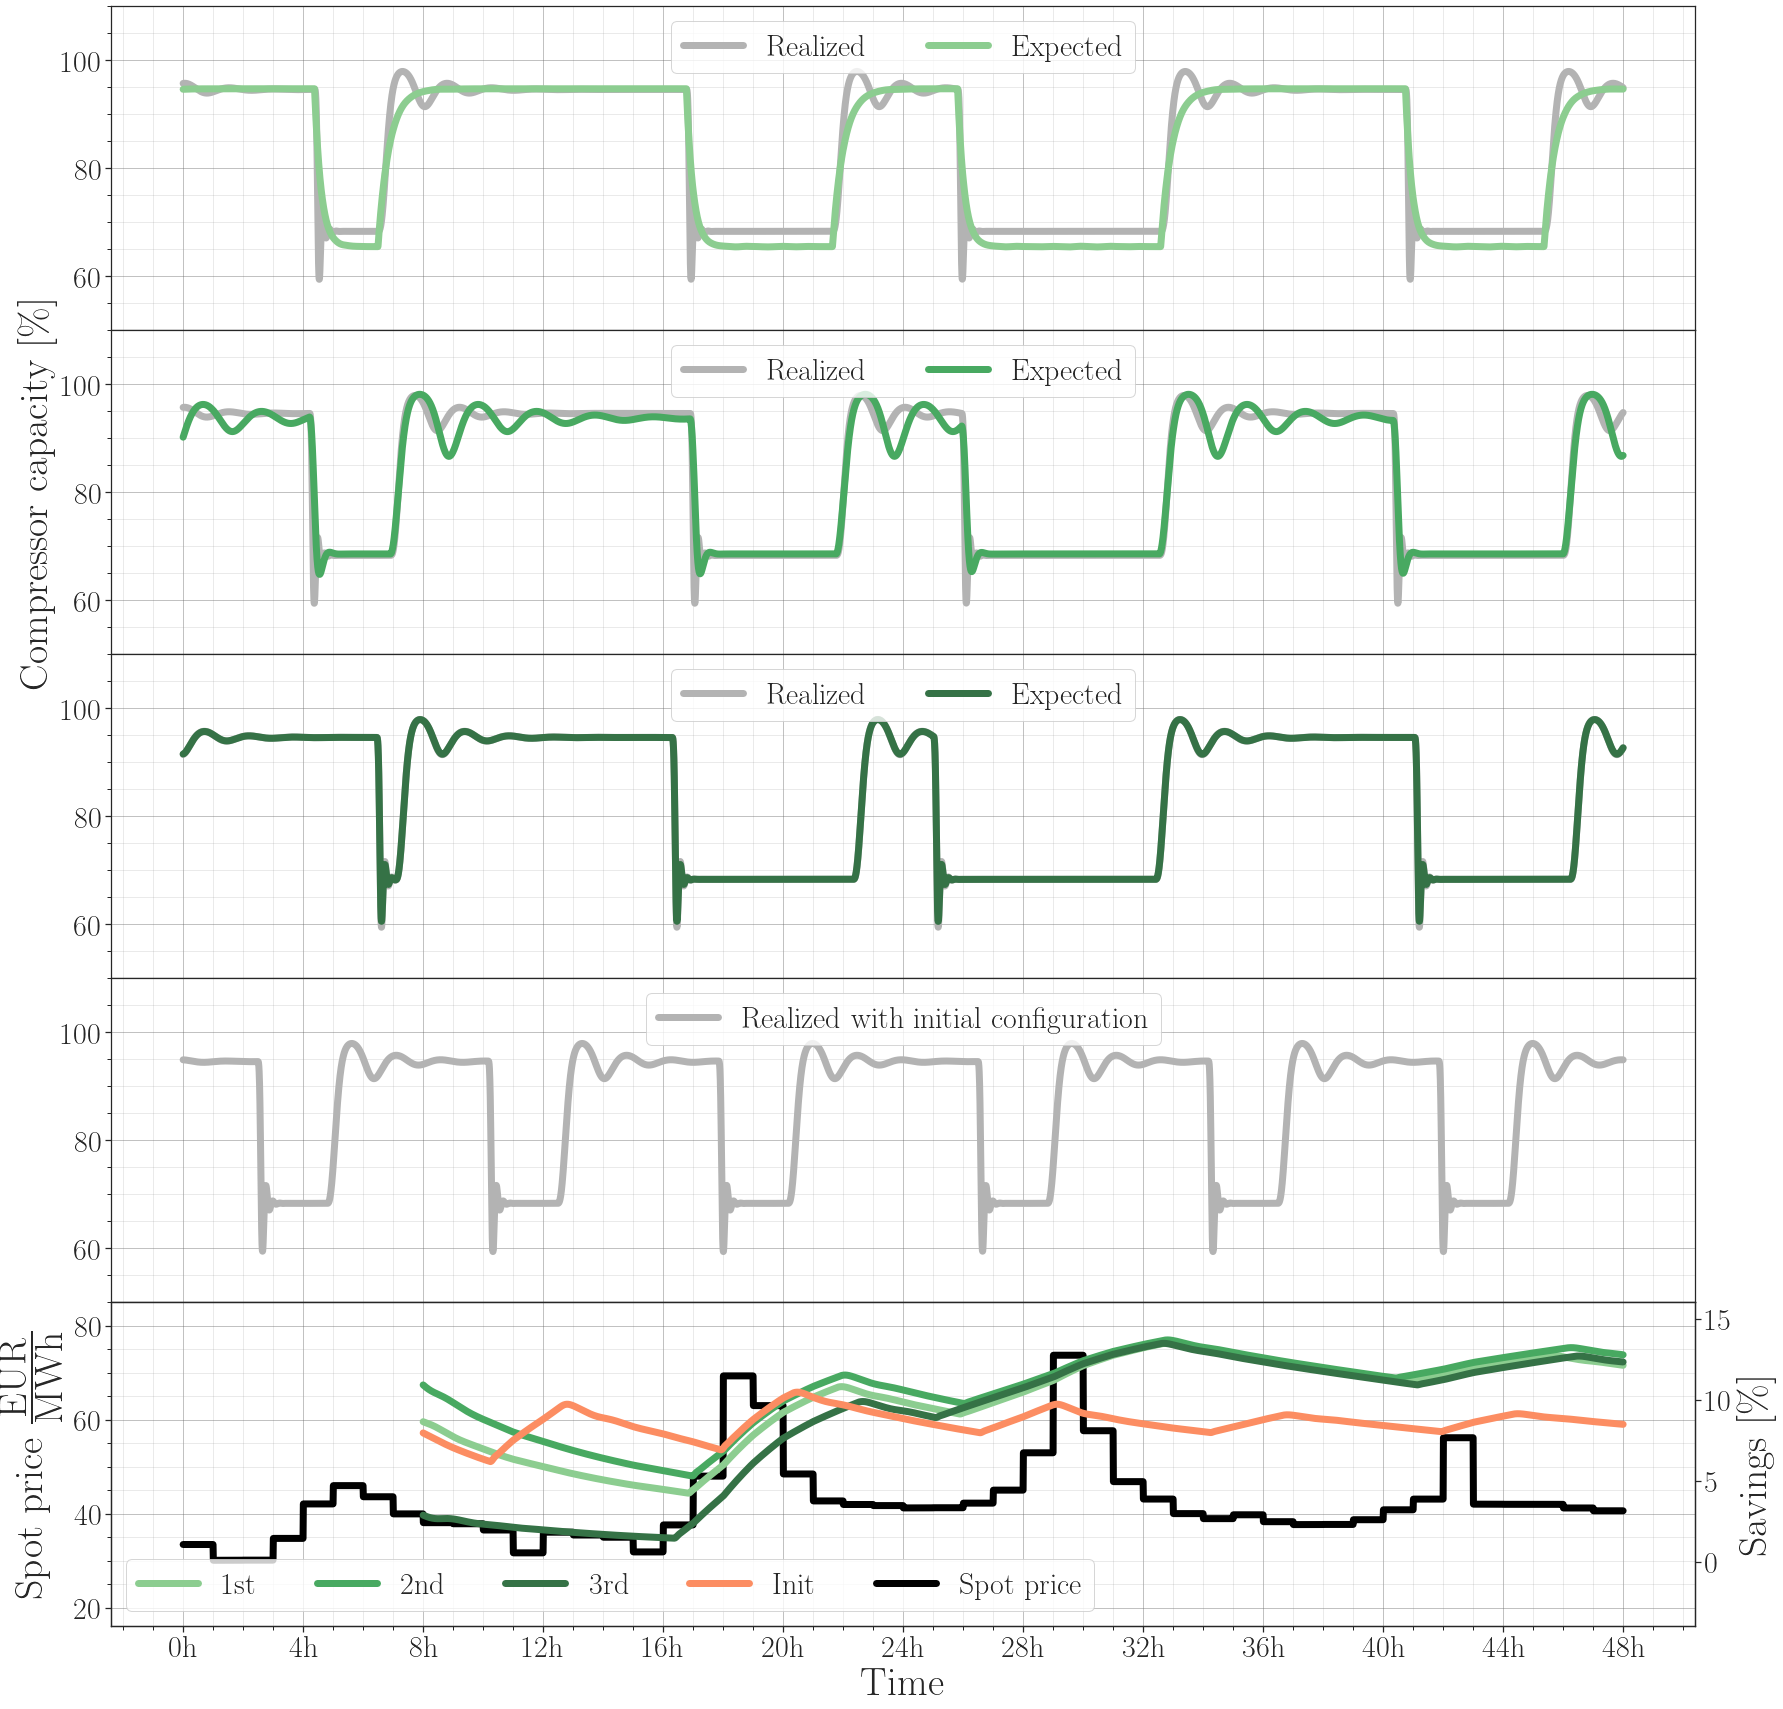

In [16]:
price_slope = 1.
days_to_plot = range(55,57)
linewidth1 = 7
linewidth2 = 7
n_skip_x = 4
histories = histories_02

fig = plt.figure(figsize=(25,25))   
ax1 = fig.add_subplot(511)

price_idle_plot =np.concatenate([histories['m1']['price_true_idle'][day] for day in days_to_plot]) - histories['m1']['price_true_idle'][days_to_plot[0]][0]

model = 'm1'
Z_model_true_plot_m1 =np.concatenate([histories[model]['Z_true'][day][0] for day in days_to_plot])
Z_model_dap_plot_m1 = np.concatenate([histories[model]['Z_model_dap'][day][0] for day in days_to_plot])
T_plot = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])
price_true_plot_m1 =np.concatenate([histories[model]['price_true'][day] for day in days_to_plot]) - histories[model]['price_true'][days_to_plot[0]][0]


ax1.plot(T_plot,100*Z_model_true_plot_m1,markersize=10,color = sns.color_palette("Set2")[-1], label=r'$\textnormal{Realized}$',alpha = 1.,linewidth=linewidth1)
ax1.plot(T_plot ,100*Z_model_dap_plot_m1,color = greens[5], label=r'$\textnormal{Expected}$',linewidth=linewidth2)

total_number_of_days = (days_to_plot[-1] - days_to_plot[0]) + 1
ax1.set_xticks(np.arange(0,total_number_of_days*25,n_skip_x)*(60.) + days_to_plot[0] * 60 * 24)
ax1.set_xticklabels(['' for _t in np.arange(0,total_number_of_days*25,n_skip_x) * 60.])
ax1.set_yticks([60, 80, 100])
setupAxis(ax1,ncol_legend = 3)
ax1.set_xlabel(r'')
ax1.set_ylabel(r'')
ax1.set_ylim(50,110)
ax1.legend(prop={'size': 30},ncol=2,loc = 'upper center')


 
ax2 = fig.add_subplot(512)

model = 'm2'
Z_model_true_plot_m2 =np.concatenate([histories[model]['Z_true'][day][0] for day in days_to_plot])
Z_model_dap_plot_m2 = np.concatenate([histories[model]['Z_model_dap'][day][0] for day in days_to_plot])
T_plot = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])
price_true_plot_m2 =np.concatenate([histories[model]['price_true'][day] for day in days_to_plot]) - histories[model]['price_true'][days_to_plot[0]][0]

ax2.plot(T_plot,100*Z_model_true_plot_m2,markersize=10,color = sns.color_palette("Set2")[-1], label=r'$\textnormal{Realized}$',alpha = 1.,linewidth=linewidth1)
ax2.plot(T_plot ,100*Z_model_dap_plot_m2,color = greens[3], label=r'$\textnormal{Expected}$',linewidth=linewidth2)

total_number_of_days = (days_to_plot[-1] - days_to_plot[0]) + 1
ax2.set_xticks(np.arange(0,total_number_of_days*25,n_skip_x)*(60.) + days_to_plot[0] * 60 * 24)
ax2.set_xticklabels(['' for _t in np.arange(0,total_number_of_days*25,n_skip_x) * 60.])
ax2.set_yticks([60, 80, 100])
setupAxis(ax2,ncol_legend = 3)
ax2.set_ylabel(r'$\textnormal{Compressor capacity [\%]} $')
ax2.set_xlabel(r'')
ax2.set_ylim(50,110)
ax2.legend(prop={'size': 30},ncol=2,loc = 'upper center')



  
ax3 = fig.add_subplot(513)
model = 'm3'
Z_model_true_plot_m3 =np.concatenate([histories[model]['Z_true'][day][0] for day in days_to_plot])
Z_model_dap_plot_m3 = np.concatenate([histories[model]['Z_model_dap'][day][0] for day in days_to_plot])
T_plot = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])
price_true_plot_m3 =np.concatenate([histories[model]['price_true'][day] for day in days_to_plot]) - histories[model]['price_true'][days_to_plot[0]][0]

ax3.plot(T_plot,100*Z_model_true_plot_m3,markersize=10,color = sns.color_palette("Set2")[-1], label=r'$\textnormal{Realized}$',alpha = 1.,linewidth=linewidth1)
ax3.plot(T_plot ,100*Z_model_dap_plot_m3,color = greens[1], label=r'$\textnormal{Expected}$',linewidth=linewidth2)

total_number_of_days = (days_to_plot[-1] - days_to_plot[0]) + 1
ax3.set_xticks(np.arange(0,total_number_of_days*25,n_skip_x)*(60.) + days_to_plot[0] * 60 * 24)
ax3.set_xticklabels(['' for _t in np.arange(0,total_number_of_days*25,n_skip_x) * 60.])
ax3.set_yticks([60, 80, 100])
setupAxis(ax3,ncol_legend = 3)
ax3.set_xlabel(r'')
ax3.set_ylabel(r'')
ax3.set_ylim(50,110)
ax3.legend(prop={'size': 30},ncol=2,loc = 'upper center')

ax4 = fig.add_subplot(514)
model = 'm3'
Z_model_true_plot_init =np.concatenate([histories[model]['Z_true_init_switch'][day][0] for day in days_to_plot])
#Z_model_dap_plot_init = np.concatenate([histories[model]['Z_true_init_switch'][day][0] for day in days_to_plot])
T_plot = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])
price_true_plot_init =np.concatenate([histories[model]['price_true_init_switch'][day] for day in days_to_plot]) - histories[model]['price_true_init_switch'][days_to_plot[0]][0]

ax4.plot(T_plot,100*Z_model_true_plot_init,markersize=10,color = sns.color_palette("Set2")[-1], label=r'$\textnormal{Realized with initial configuration}$',alpha = 1.,linewidth=linewidth1)
#ax4.plot(T_plot ,100*Z_model_dap_plot_init,color = greens[1], label=r'$\textnormal{Expected}$',linewidth=linewidth2)

total_number_of_days = (days_to_plot[-1] - days_to_plot[0]) + 1
ax4.set_xticks(np.arange(0,total_number_of_days*25,n_skip_x)*(60.) + days_to_plot[0] * 60 * 24)
ax4.set_xticklabels(['' for _t in np.arange(0,total_number_of_days*25,n_skip_x) * 60.])
ax4.set_yticks([60, 80, 100])
setupAxis(ax4,ncol_legend = 3)
ax4.set_xlabel(r'')
ax4.set_ylabel(r'')
ax4.set_ylim(50,110)
ax4.legend(prop={'size': 30},ncol=2,loc = 'upper center')


ax5 = fig.add_subplot(515)
all_dap = np.concatenate([histories[model]['PRICES_dap'][day,:24] for day in days_to_plot])
all_time = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])

lprice = ax5.plot(all_time,smooth_dap(all_time - all_time[0],all_dap,100,48),color='black',linewidth=linewidth2, label=r'$\textnormal{Spot price}$')

#ax4.plot(all_time,smooth_dap(all_time - all_time[0],all_dap,0.2,48),color=red[2],linewidth=linewidth1)
ax5.set_xticks(np.arange(0,total_number_of_days*25,4)*(60.) + days_to_plot[0] * 60 * 24)
ax5.set_xticklabels(['$'+str(int(_t/60.)) + r' \textnormal{h}$' for _t in np.arange(0,total_number_of_days*25,4) * 60.])
setupAxis(ax5,ncol_legend = 3,nolegend=True)
ax5.set_ylabel(r'$\textnormal{Spot price } \frac{\textnormal{EUR}}{\textnormal{MWh}}$')
ax5.set_xlabel(r'$\textnormal{Time} $')

ax5.set_ylim(16,85)

ax5_2 = ax5.twinx()
l1 = ax5_2.plot(all_time[2400:],(100*(price_idle_plot - price_true_plot_m1)/price_idle_plot)[2400:],color=greens[5],linewidth=linewidth2, label=r'$\textnormal{1st}$')
l2 = ax5_2.plot(all_time[2400:],(100*(price_idle_plot - price_true_plot_m2)/price_idle_plot)[2400:],color=greens[3],linewidth=linewidth2, label=r'$\textnormal{2nd}$')
l3 = ax5_2.plot(all_time[2400:],(100*(price_idle_plot - price_true_plot_m3)/price_idle_plot)[2400:],color=greens[1],linewidth=linewidth2, label=r'$\textnormal{3rd}$')
l4 = ax5_2.plot(all_time[2400:],(100*(price_idle_plot - price_true_plot_init)/price_idle_plot)[2400:],color=sns.color_palette("Set2")[1],linewidth=linewidth2, label=r'$\textnormal{Init}$')

#ax5_2.set_yticks(np.array([0,4,8,12]))
ax5_2.set_ylabel(r'$\textnormal{Savings [\%]}$', fontsize=40)

ax5_2.tick_params(axis="y", labelsize=30)

lns = l1+l2+l3+l4+lprice
labs = [l.get_label() for l in lns]
ax5_2.legend(lns, labs,ncol=5,prop={'size': 30})
ax5_2.set_ylim(-4,16)



plt.subplots_adjust(hspace = 0.,bottom=0.05, top =0.95,left = 0.07, right = 0.95,)

plt.savefig(FIGS + '/simulation/specific_day_with_init_reuse.pdf',format='pdf')

prices_used = prices['2018-01-01 12:00:00':]
print(prices_used.iloc[(24*days_to_plot[0])])


/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide
/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in true_divide
/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in true_divide


spot                      38.15
down                      34.08
up                        38.16
market_spot                   0
market_down                   1
market_up                     0
RK                        34.08
t_sin               1.22465e-16
market_class_all              0
Name: 2018-04-01 12:00:00, dtype: object


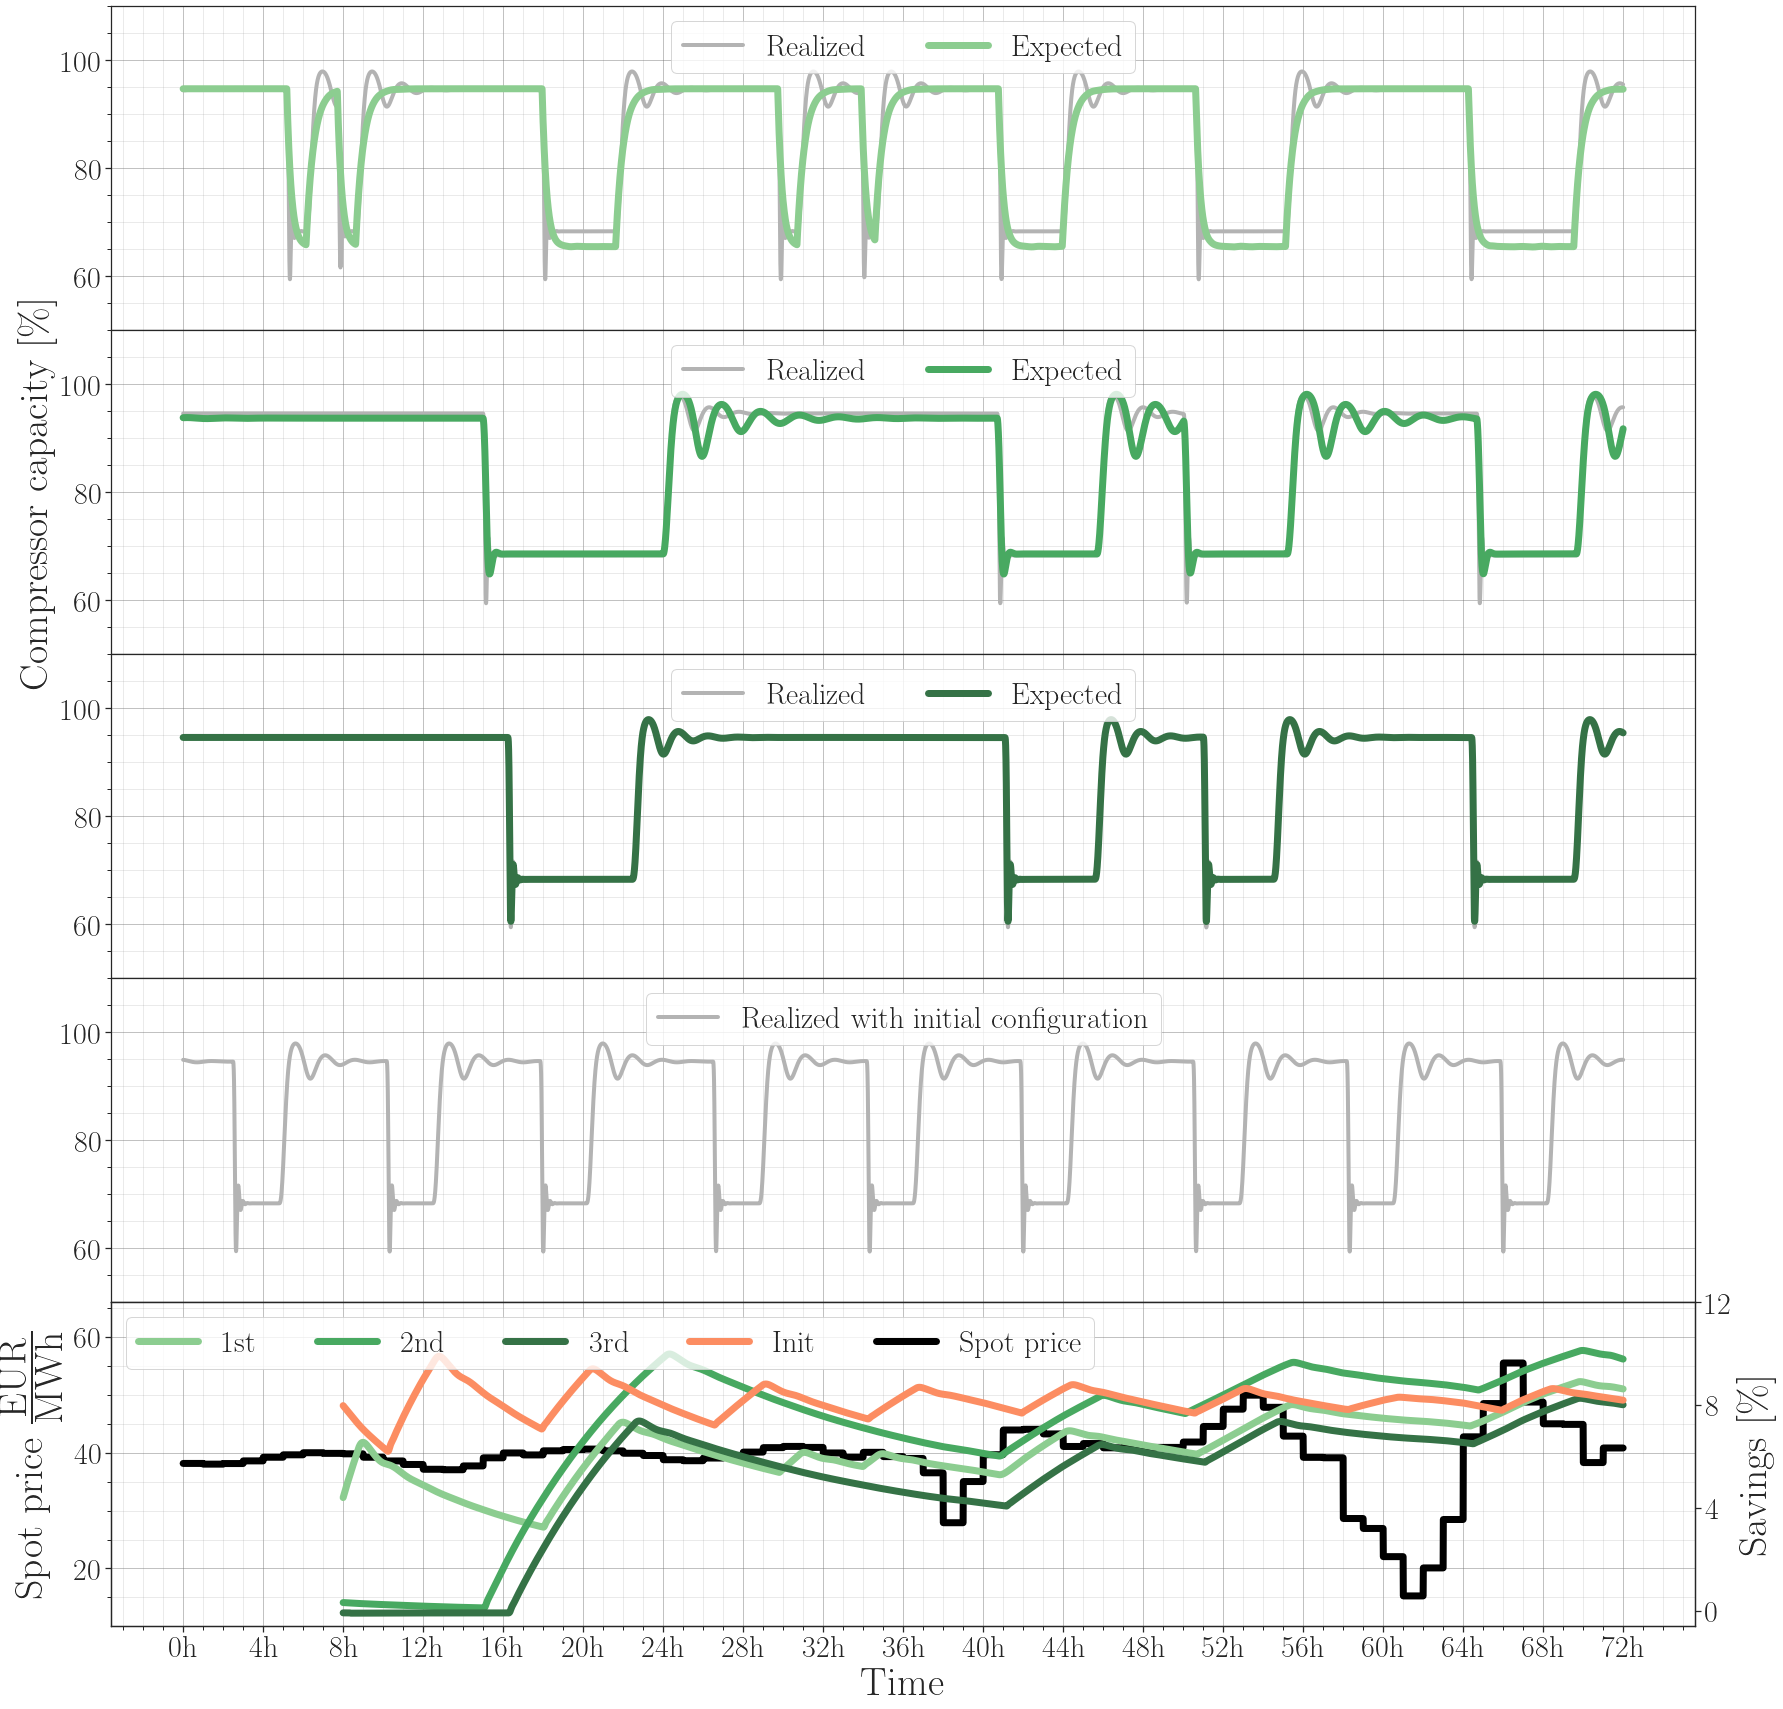

In [17]:
price_slope = 1.
days_to_plot = range(90,93)
linewidth1 = 4
linewidth2 = 7
n_skip_x = 4
histories = histories_02

fig = plt.figure(figsize=(25,25))   
ax1 = fig.add_subplot(511)

price_idle_plot =np.concatenate([histories['m1']['price_true_idle'][day] for day in days_to_plot]) - histories['m1']['price_true_idle'][days_to_plot[0]][0]

model = 'm1'
Z_model_true_plot_m1 =np.concatenate([histories[model]['Z_true'][day][0] for day in days_to_plot])
Z_model_dap_plot_m1 = np.concatenate([histories[model]['Z_model_dap'][day][0] for day in days_to_plot])
T_plot = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])
price_true_plot_m1 =np.concatenate([histories[model]['price_true'][day] for day in days_to_plot]) - histories[model]['price_true'][days_to_plot[0]][0]


ax1.plot(T_plot,100*Z_model_true_plot_m1,markersize=10,color = sns.color_palette("Set2")[-1], label=r'$\textnormal{Realized}$',alpha = 1.,linewidth=linewidth1)
ax1.plot(T_plot ,100*Z_model_dap_plot_m1,color = greens[5], label=r'$\textnormal{Expected}$',linewidth=linewidth2)

total_number_of_days = (days_to_plot[-1] - days_to_plot[0]) + 1
ax1.set_xticks(np.arange(0,total_number_of_days*25,n_skip_x)*(60.) + days_to_plot[0] * 60 * 24)
ax1.set_xticklabels(['' for _t in np.arange(0,total_number_of_days*25,n_skip_x) * 60.])
ax1.set_yticks([60, 80, 100])
setupAxis(ax1,ncol_legend = 3)
ax1.set_xlabel(r'')
ax1.set_ylabel(r'')
ax1.set_ylim(50,110)
ax1.legend(prop={'size': 30},ncol=2,loc = 'upper center')


 
ax2 = fig.add_subplot(512)

model = 'm2'
Z_model_true_plot_m2 =np.concatenate([histories[model]['Z_true'][day][0] for day in days_to_plot])
Z_model_dap_plot_m2 = np.concatenate([histories[model]['Z_model_dap'][day][0] for day in days_to_plot])
T_plot = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])
price_true_plot_m2 =np.concatenate([histories[model]['price_true'][day] for day in days_to_plot]) - histories[model]['price_true'][days_to_plot[0]][0]

ax2.plot(T_plot,100*Z_model_true_plot_m2,markersize=10,color = sns.color_palette("Set2")[-1], label=r'$\textnormal{Realized}$',alpha = 1.,linewidth=linewidth1)
ax2.plot(T_plot ,100*Z_model_dap_plot_m2,color = greens[3], label=r'$\textnormal{Expected}$',linewidth=linewidth2)

total_number_of_days = (days_to_plot[-1] - days_to_plot[0]) + 1
ax2.set_xticks(np.arange(0,total_number_of_days*25,n_skip_x)*(60.) + days_to_plot[0] * 60 * 24)
ax2.set_xticklabels(['' for _t in np.arange(0,total_number_of_days*25,n_skip_x) * 60.])
ax2.set_yticks([60, 80, 100])
setupAxis(ax2,ncol_legend = 3)
ax2.set_ylabel(r'$\textnormal{Compressor capacity [\%]} $')
ax2.set_xlabel(r'')
ax2.set_ylim(50,110)
ax2.legend(prop={'size': 30},ncol=2,loc = 'upper center')



  
ax3 = fig.add_subplot(513)
model = 'm3'
Z_model_true_plot_m3 =np.concatenate([histories[model]['Z_true'][day][0] for day in days_to_plot])
Z_model_dap_plot_m3 = np.concatenate([histories[model]['Z_model_dap'][day][0] for day in days_to_plot])
T_plot = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])
price_true_plot_m3 =np.concatenate([histories[model]['price_true'][day] for day in days_to_plot]) - histories[model]['price_true'][days_to_plot[0]][0]

ax3.plot(T_plot,100*Z_model_true_plot_m3,markersize=10,color = sns.color_palette("Set2")[-1], label=r'$\textnormal{Realized}$',alpha = 1.,linewidth=linewidth1)
ax3.plot(T_plot ,100*Z_model_dap_plot_m3,color = greens[1], label=r'$\textnormal{Expected}$',linewidth=linewidth2)

total_number_of_days = (days_to_plot[-1] - days_to_plot[0]) + 1
ax3.set_xticks(np.arange(0,total_number_of_days*25,n_skip_x)*(60.) + days_to_plot[0] * 60 * 24)
ax3.set_xticklabels(['' for _t in np.arange(0,total_number_of_days*25,n_skip_x) * 60.])
ax3.set_yticks([60, 80, 100])
setupAxis(ax3,ncol_legend = 3)
ax3.set_xlabel(r'')
ax3.set_ylabel(r'')
ax3.set_ylim(50,110)
ax3.legend(prop={'size': 30},ncol=2,loc = 'upper center')

ax4 = fig.add_subplot(514)
model = 'm3'
Z_model_true_plot_init =np.concatenate([histories[model]['Z_true_init_switch'][day][0] for day in days_to_plot])
#Z_model_dap_plot_init = np.concatenate([histories[model]['Z_true_init_switch'][day][0] for day in days_to_plot])
T_plot = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])
price_true_plot_init =np.concatenate([histories[model]['price_true_init_switch'][day] for day in days_to_plot]) - histories[model]['price_true_init_switch'][days_to_plot[0]][0]

ax4.plot(T_plot,100*Z_model_true_plot_init,markersize=10,color = sns.color_palette("Set2")[-1], label=r'$\textnormal{Realized with initial configuration}$',alpha = 1.,linewidth=linewidth1)
#ax4.plot(T_plot ,100*Z_model_dap_plot_init,color = greens[1], label=r'$\textnormal{Expected}$',linewidth=linewidth2)

total_number_of_days = (days_to_plot[-1] - days_to_plot[0]) + 1
ax4.set_xticks(np.arange(0,total_number_of_days*25,n_skip_x)*(60.) + days_to_plot[0] * 60 * 24)
ax4.set_xticklabels(['' for _t in np.arange(0,total_number_of_days*25,n_skip_x) * 60.])
ax4.set_yticks([60, 80, 100])
setupAxis(ax4,ncol_legend = 3)
ax4.set_xlabel(r'')
ax4.set_ylabel(r'')
ax4.set_ylim(50,110)
ax4.legend(prop={'size': 30},ncol=2,loc = 'upper center')


ax5 = fig.add_subplot(515)
all_dap = np.concatenate([histories[model]['PRICES_dap'][day,:24] for day in days_to_plot])
all_time = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])

lprice = ax5.plot(all_time,smooth_dap(all_time - all_time[0],all_dap,100,72),color='black',linewidth=linewidth2, label=r'$\textnormal{Spot price}$')

#ax4.plot(all_time,smooth_dap(all_time - all_time[0],all_dap,0.2,48),color=red[2],linewidth=linewidth1)
ax5.set_xticks(np.arange(0,total_number_of_days*25,4)*(60.) + days_to_plot[0] * 60 * 24)
ax5.set_xticklabels(['$'+str(int(_t/60.)) + r' \textnormal{h}$' for _t in np.arange(0,total_number_of_days*25,4) * 60.])
setupAxis(ax5,ncol_legend = 3,nolegend=True)
ax5.set_ylabel(r'$\textnormal{Spot price } \frac{\textnormal{EUR}}{\textnormal{MWh}}$')
ax5.set_xlabel(r'$\textnormal{Time} $')

ax5.set_ylim(10,66)

ax5_2 = ax5.twinx()
l1 = ax5_2.plot(all_time[2400:],(100*(price_idle_plot - price_true_plot_m1)/price_idle_plot)[2400:],color=greens[5],linewidth=linewidth2, label=r'$\textnormal{1st}$')
l2 = ax5_2.plot(all_time[2400:],(100*(price_idle_plot - price_true_plot_m2)/price_idle_plot)[2400:],color=greens[3],linewidth=linewidth2, label=r'$\textnormal{2nd}$')
l3 = ax5_2.plot(all_time[2400:],(100*(price_idle_plot - price_true_plot_m3)/price_idle_plot)[2400:],color=greens[1],linewidth=linewidth2, label=r'$\textnormal{3rd}$')
l4 = ax5_2.plot(all_time[2400:],(100*(price_idle_plot - price_true_plot_init)/price_idle_plot)[2400:],color=sns.color_palette("Set2")[1],linewidth=linewidth2, label=r'$\textnormal{Init}$')

ax5_2.set_yticks(np.array([0,4,8,12]))
ax5_2.set_ylabel(r'$\textnormal{Savings [\%]}$', fontsize=40)

ax5_2.tick_params(axis="y", labelsize=30)

lns = l1+l2+l3+l4+lprice
labs = [l.get_label() for l in lns]
ax5_2.legend(lns, labs,ncol=5,prop={'size': 30},loc='upper left')



plt.subplots_adjust(hspace = 0.,bottom=0.05)

plt.subplots_adjust(hspace = 0.,bottom=0.05, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/specific_day_borring_and_wild_reuse.pdf',format='pdf')

prices_used = prices['2018-01-01 12:00:00':]
print(prices_used.iloc[(24*days_to_plot[0])])


/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


spot                      38.15
down                      34.08
up                        38.16
market_spot                   0
market_down                   1
market_up                     0
RK                        34.08
t_sin               1.22465e-16
market_class_all              0
Name: 2018-04-01 12:00:00, dtype: object


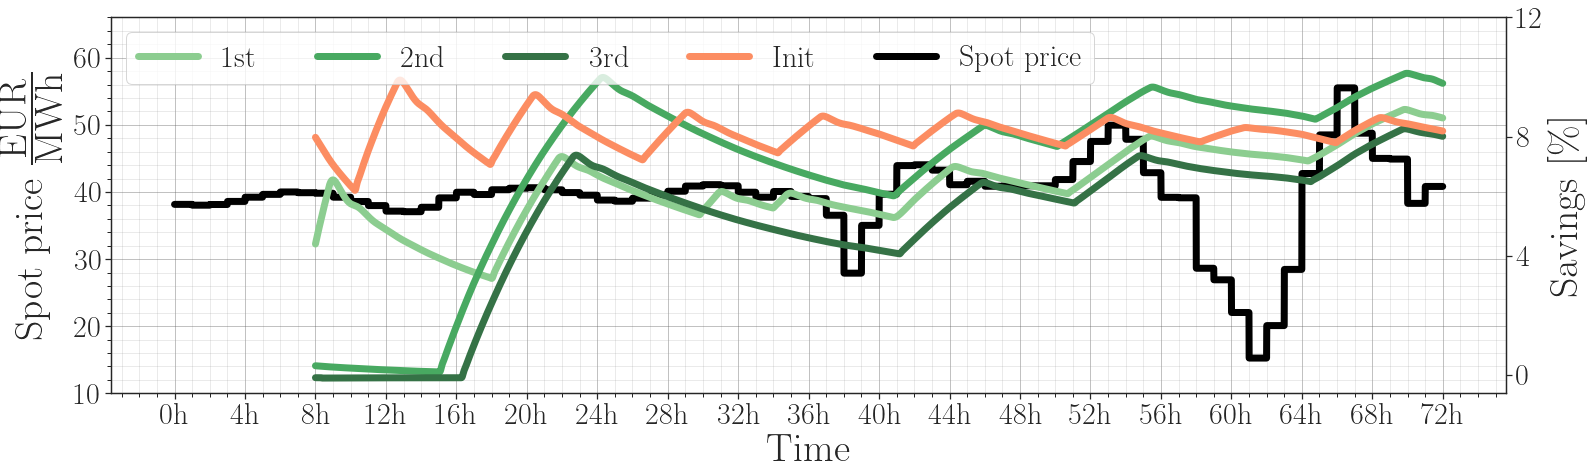

In [18]:
price_slope = 1.
days_to_plot = range(90,93)
linewidth1 = 4
linewidth2 = 7
n_skip_x = 4
histories = histories_02

fig = plt.figure(figsize=(25,9))   
ax1 = fig.add_subplot(111)

price_idle_plot =np.concatenate([histories['m1']['price_true_idle'][day] for day in days_to_plot]) - histories['m1']['price_true_idle'][days_to_plot[0]][0]

model = 'm1'
Z_model_true_plot_m1 =np.concatenate([histories[model]['Z_true'][day][0] for day in days_to_plot])
Z_model_dap_plot_m1 = np.concatenate([histories[model]['Z_model_dap'][day][0] for day in days_to_plot])
T_plot = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])
price_true_plot_m1 =np.concatenate([histories[model]['price_true'][day] for day in days_to_plot]) - histories[model]['price_true'][days_to_plot[0]][0]



model = 'm2'
Z_model_true_plot_m2 =np.concatenate([histories[model]['Z_true'][day][0] for day in days_to_plot])
Z_model_dap_plot_m2 = np.concatenate([histories[model]['Z_model_dap'][day][0] for day in days_to_plot])
T_plot = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])
price_true_plot_m2 =np.concatenate([histories[model]['price_true'][day] for day in days_to_plot]) - histories[model]['price_true'][days_to_plot[0]][0]


model = 'm3'
Z_model_true_plot_m3 =np.concatenate([histories[model]['Z_true'][day][0] for day in days_to_plot])
Z_model_dap_plot_m3 = np.concatenate([histories[model]['Z_model_dap'][day][0] for day in days_to_plot])
T_plot = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])
price_true_plot_m3 =np.concatenate([histories[model]['price_true'][day] for day in days_to_plot]) - histories[model]['price_true'][days_to_plot[0]][0]


model = 'm3'
Z_model_true_plot_init =np.concatenate([histories[model]['Z_true_init_switch'][day][0] for day in days_to_plot])
#Z_model_dap_plot_init = np.concatenate([histories[model]['Z_true_init_switch'][day][0] for day in days_to_plot])
T_plot = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])
price_true_plot_init =np.concatenate([histories[model]['price_true_init_switch'][day] for day in days_to_plot]) - histories[model]['price_true_init_switch'][days_to_plot[0]][0]


ax5 = fig.add_subplot(111)
all_dap = np.concatenate([histories[model]['PRICES_dap'][day,:24] for day in days_to_plot])
all_time = np.concatenate([histories[model]['T'][0] + day * 60*24 for day in days_to_plot])

lprice = ax5.plot(all_time,smooth_dap(all_time - all_time[0],all_dap,100,72),color='black',linewidth=linewidth2, label=r'$\textnormal{Spot price}$')

#ax4.plot(all_time,smooth_dap(all_time - all_time[0],all_dap,0.2,48),color=red[2],linewidth=linewidth1)
ax5.set_xticks(np.arange(0,total_number_of_days*25,4)*(60.) + days_to_plot[0] * 60 * 24)
ax5.set_xticklabels(['$'+str(int(_t/60.)) + r' \textnormal{h}$' for _t in np.arange(0,total_number_of_days*25,4) * 60.])
setupAxis(ax5,ncol_legend = 3,nolegend=True)
ax5.set_ylabel(r'$\textnormal{Spot price } \frac{\textnormal{EUR}}{\textnormal{MWh}}$')
ax5.set_xlabel(r'$\textnormal{Time} $')

ax5.set_ylim(10,66)

ax5_2 = ax5.twinx()
l1 = ax5_2.plot(all_time[2400:],(100*(price_idle_plot - price_true_plot_m1)/price_idle_plot)[2400:],color=greens[5],linewidth=linewidth2, label=r'$\textnormal{1st}$')
l2 = ax5_2.plot(all_time[2400:],(100*(price_idle_plot - price_true_plot_m2)/price_idle_plot)[2400:],color=greens[3],linewidth=linewidth2, label=r'$\textnormal{2nd}$')
l3 = ax5_2.plot(all_time[2400:],(100*(price_idle_plot - price_true_plot_m3)/price_idle_plot)[2400:],color=greens[1],linewidth=linewidth2, label=r'$\textnormal{3rd}$')
l4 = ax5_2.plot(all_time[2400:],(100*(price_idle_plot - price_true_plot_init)/price_idle_plot)[2400:],color=sns.color_palette("Set2")[1],linewidth=linewidth2, label=r'$\textnormal{Init}$')

ax5_2.set_yticks(np.array([0,4,8,12]))

ax5_2.set_ylabel(r'$\textnormal{Savings [\%]}$', fontsize=40)

ax5_2.tick_params(axis="y", labelsize=30)

lns = l1+l2+l3+l4+lprice
labs = [l.get_label() for l in lns]
ax5_2.legend(lns, labs,ncol=5,prop={'size': 30},loc='upper left')



plt.subplots_adjust(hspace = 0.,bottom=0.3)

plt.savefig(FIGS + '/simulation/specific_day_borring_and_wild_sub_reuse.pdf',format='pdf')

prices_used = prices['2018-01-01 12:00:00':]
print(prices_used.iloc[(24*days_to_plot[0])])
